## EDA on determining Influential Users criteria

In [31]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)

In [32]:
df = pd.read_parquet('../data/raw/reviews_2024-11-25_22-13_PH.parquet', engine = 'pyarrow')
df.head()

reviewId           userName  \
0  2239ead0-76d7-4c95-ba2e-3b4c8d30afbb              Boy Z   
1  c0f25990-fffa-4302-8b80-6bd598b3b682               Jill   
2  9b502d4b-4595-404b-a845-48c946f4c574      Hashir Ashfaq   
3  cc36d108-07ef-4aa3-839f-dbe3b450bf74  KeanuSandra Mabry   
4  6f509403-c2ee-479e-89f0-2d15697c0f5e    Zanele Gwamanda   

                                           userImage  \
0  https://play-lh.googleusercontent.com/a/ACg8oc...   
1  https://play-lh.googleusercontent.com/a/ACg8oc...   
2  https://play-lh.googleusercontent.com/a/ACg8oc...   
3  https://play-lh.googleusercontent.com/a/ACg8oc...   
4  https://play-lh.googleusercontent.com/a/ACg8oc...   

                                             content  score  thumbsUpCount  \
0                                            AaB bCc      5              0   
1  i love it and its good for my daughter she rea...      5              0   
2                                                amp      5              0   
3  I would be proud to do this I wished I would h...      5              0   
4                                               free      3              0   

  reviewCreatedVersion                  at replyContent repliedAt appVersion  \
0                 None 2024-11-24 11:29:25         None       NaT       None   
1                2.0.6 2024-11-24 10:00:04         None       NaT      2.0.6   
2                 None 2024-11-24 03:33:30         None       NaT       None   
3                2.0.6 2024-11-24 02:20:33         None       NaT      2.0.6   
4                2.0.6 2024-11-24 01:04:33         None       NaT      2.0.6   

                                               appId  
0  com.rvappstudios.abc_kids_toddler_tracing_phonics  
1  com.rvappstudios.abc_kids_toddler_tracing_phonics  
2  com.rvappstudios.abc_kids_toddler_tracing_phonics  
3  com.rvappstudios.abc_kids_toddler_tracing_phonics  
4  com.rvappstudios.abc_kids_toddler_tracing_phonics

Determine % of NA's

In [33]:
print("% of NA's per Feature/Col")
print('-------------------------')
round(df.isna().sum()*100/len(df), 2)

% of NA's per Feature/Col
-------------------------


reviewId                 0.00
userName                 0.00
userImage                0.00
content                  0.01
score                    0.00
thumbsUpCount            0.00
reviewCreatedVersion    25.89
at                       0.00
replyContent            72.48
repliedAt               72.48
appVersion              25.89
appId                    0.00
dtype: float64

Its a good thing that there are just 0.01% NA's in the content/review feature.

### Score Ratings

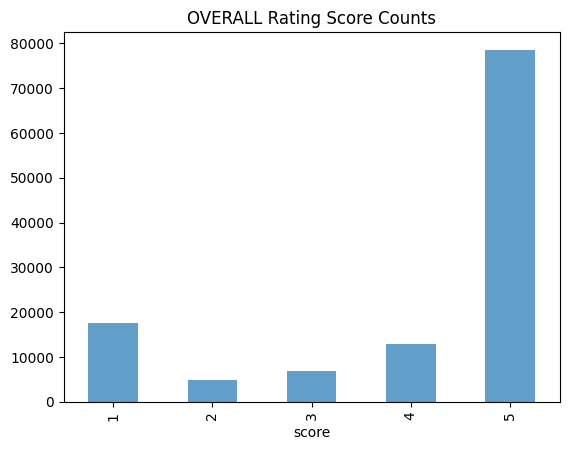

In [34]:
(df['score'].value_counts().sort_index()).plot(kind = 'bar', alpha =0.7)
plt.title('OVERALL Rating Score Counts')
plt.show()

Each Game's Score Ratings

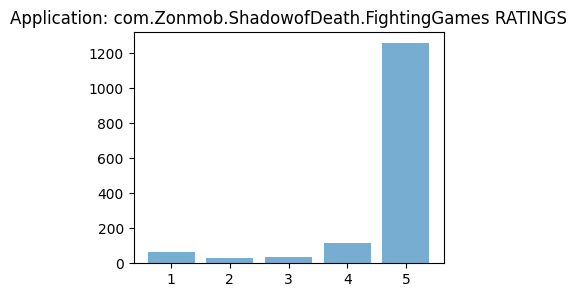

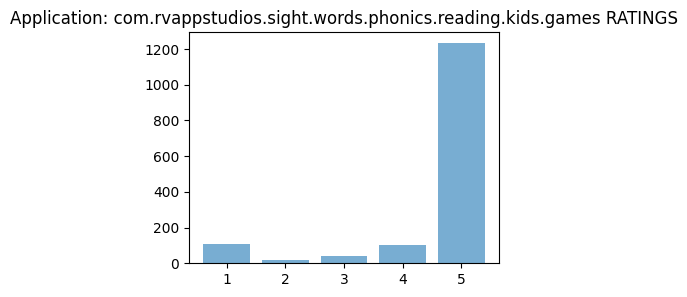

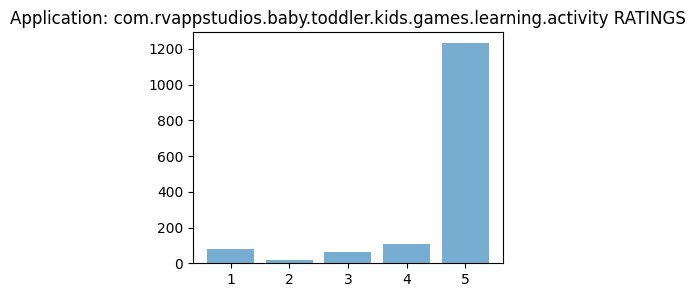

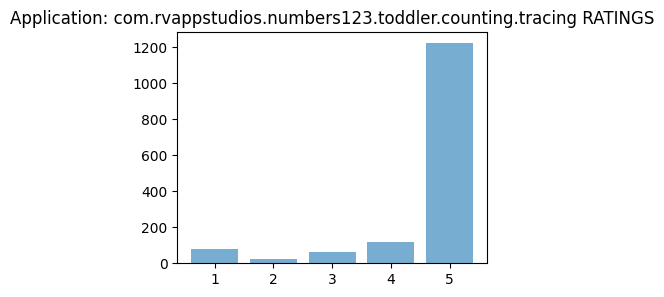

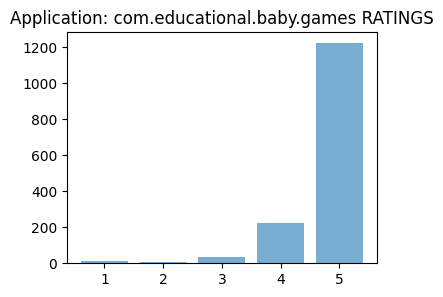

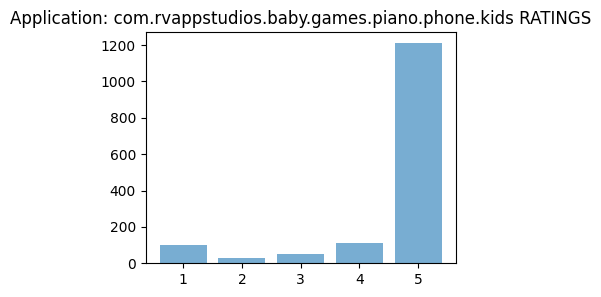

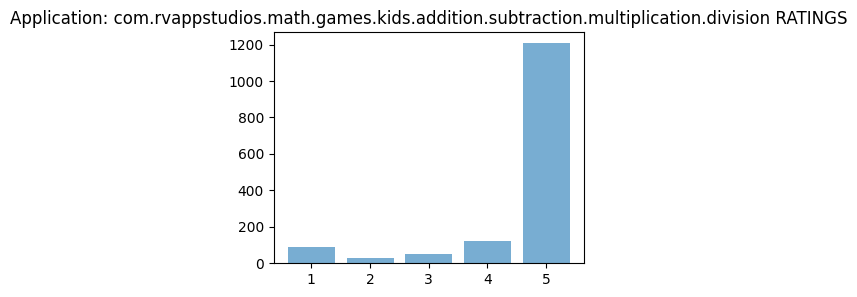

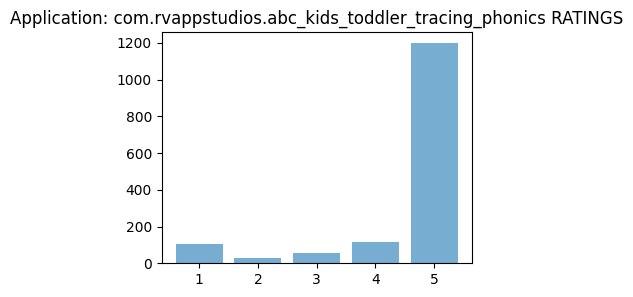

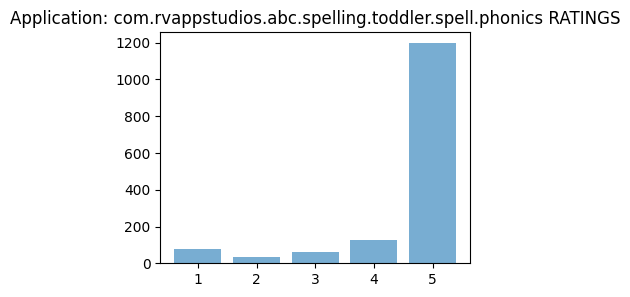

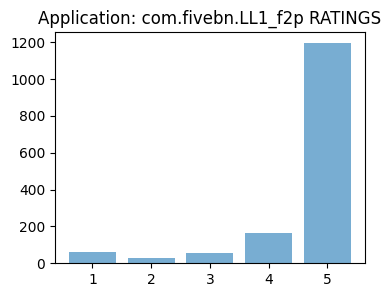

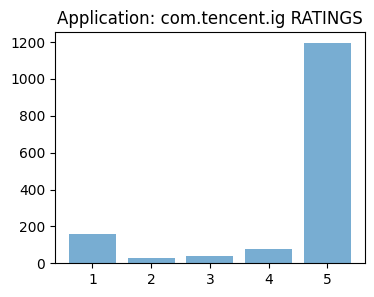

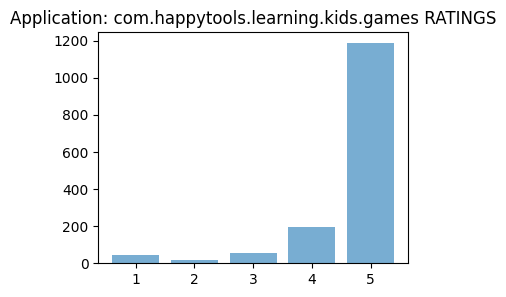

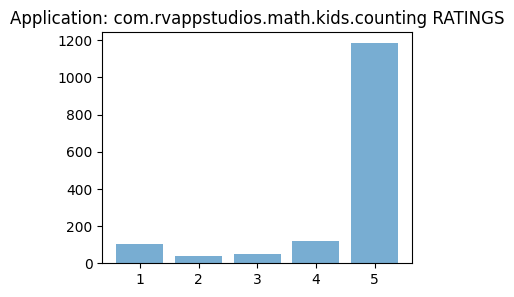

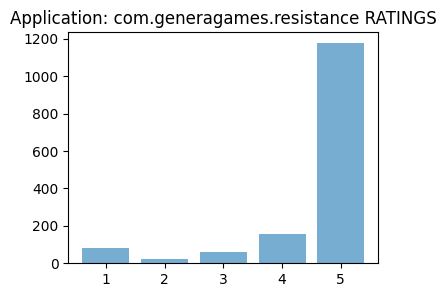

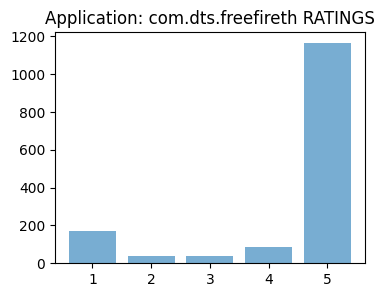

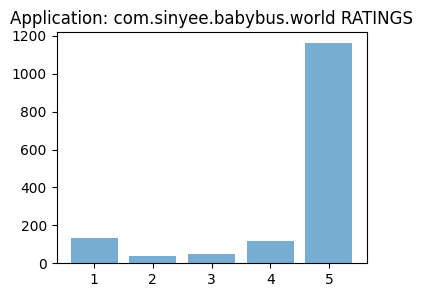

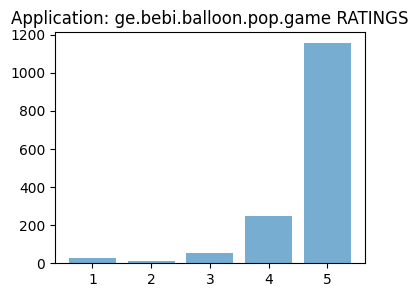

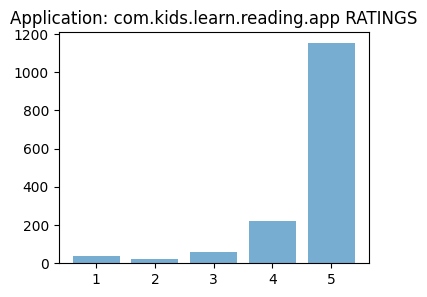

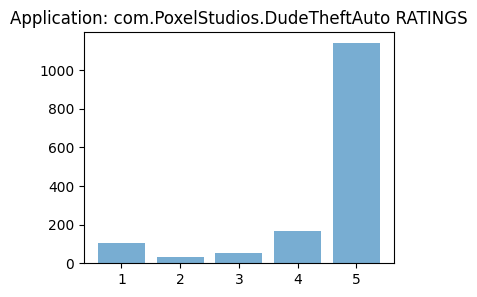

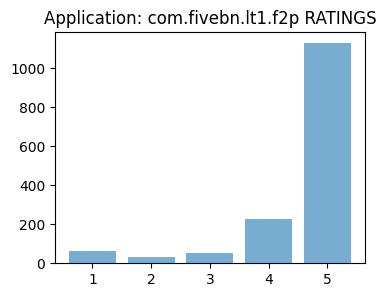

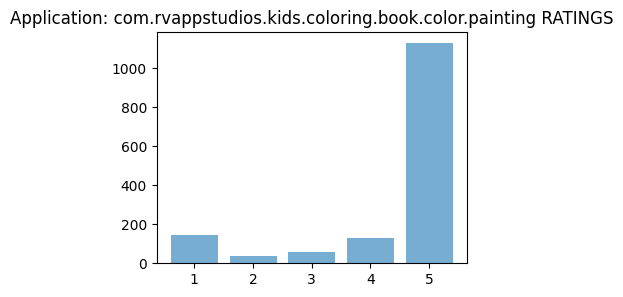

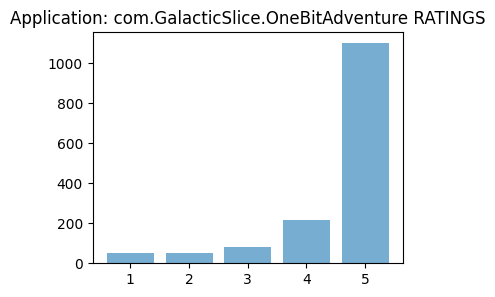

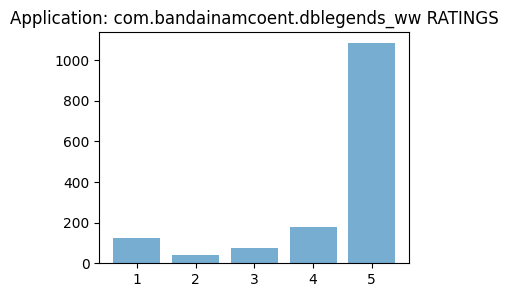

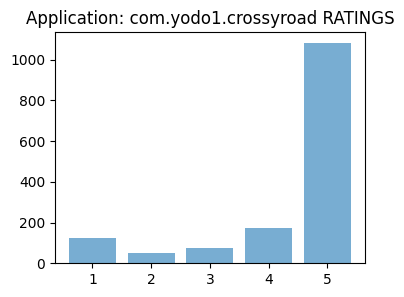

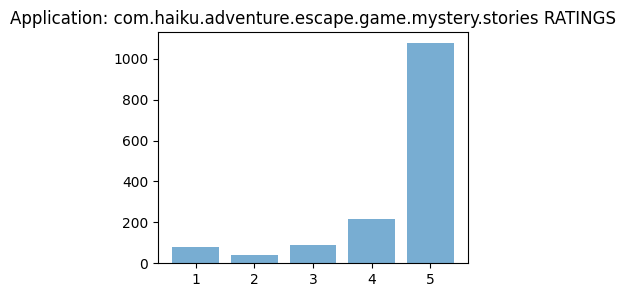

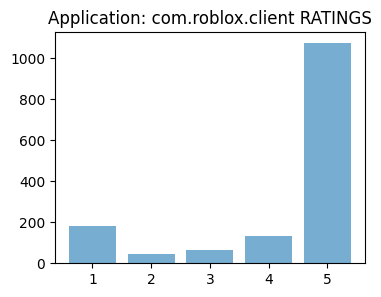

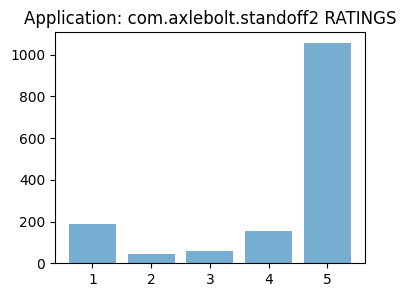

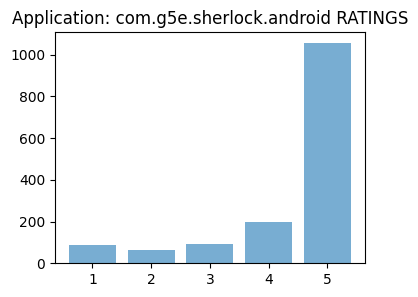

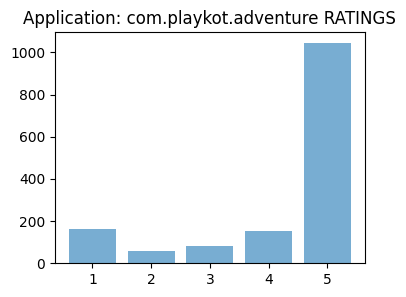

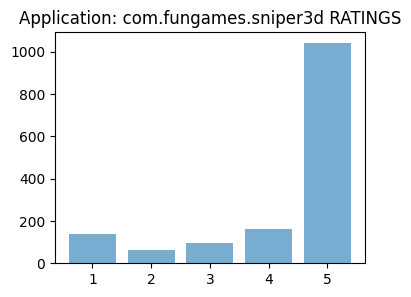

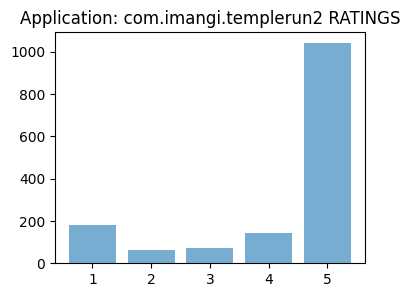

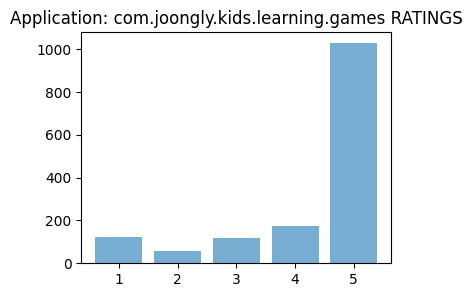

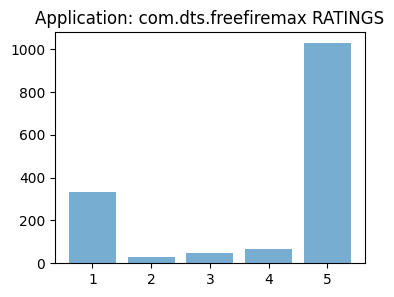

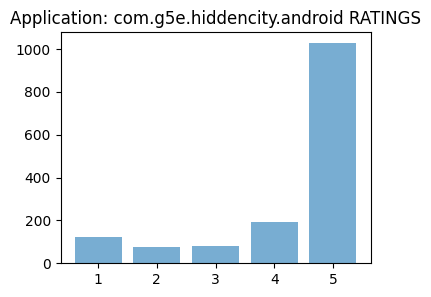

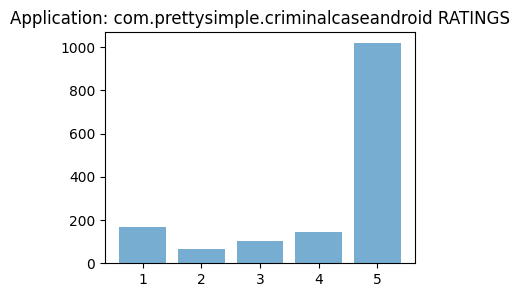

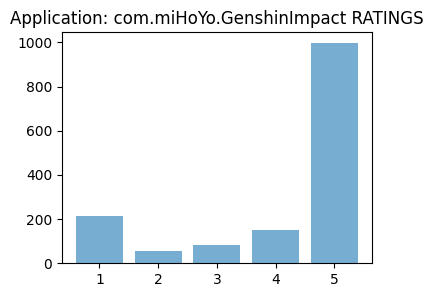

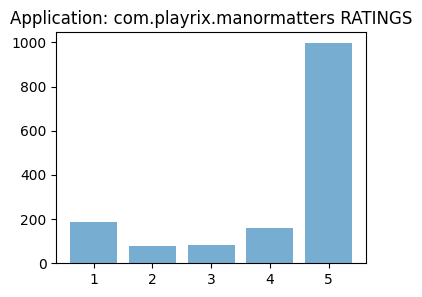

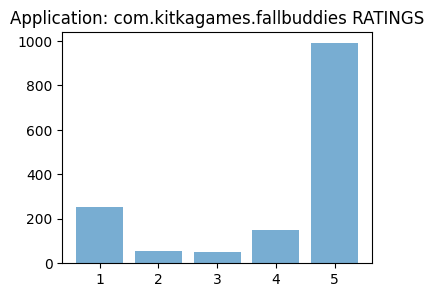

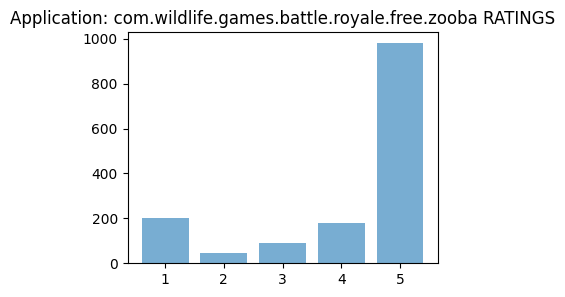

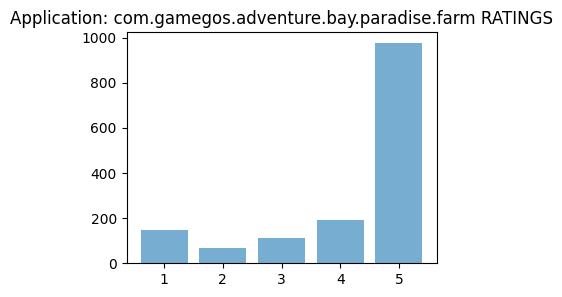

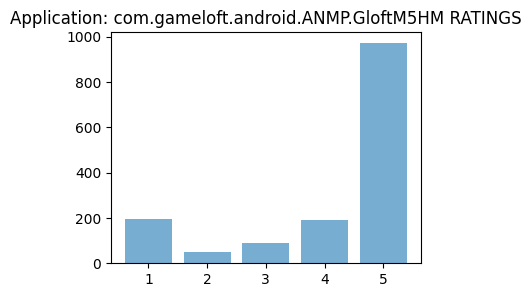

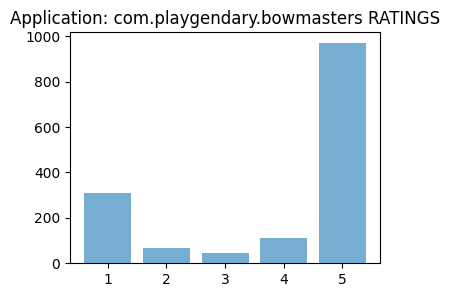

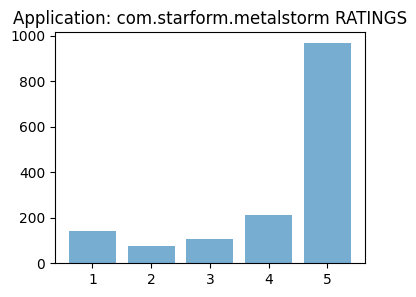

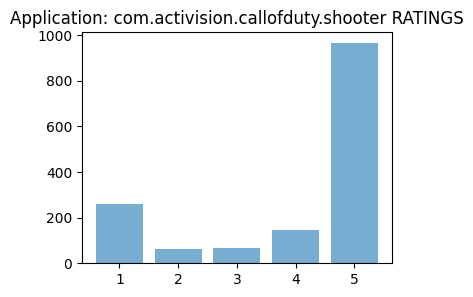

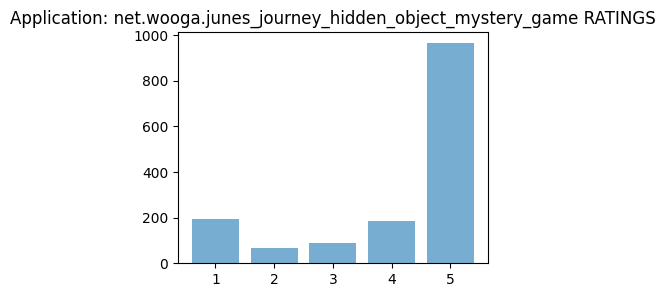

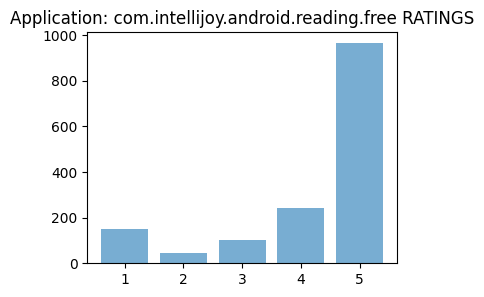

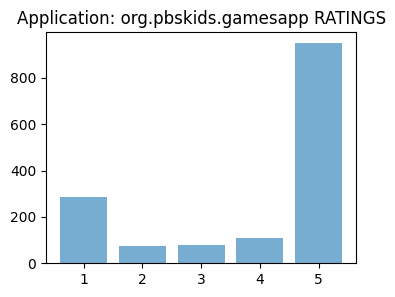

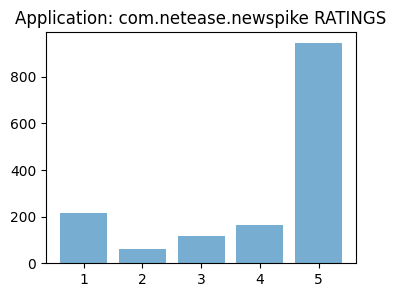

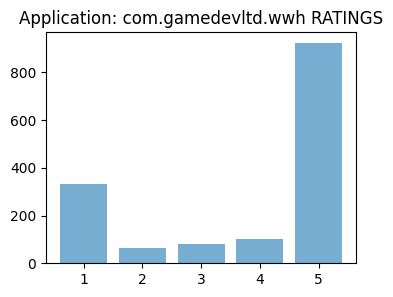

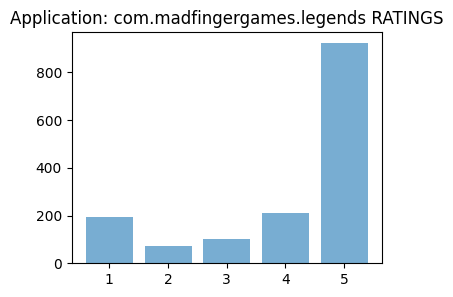

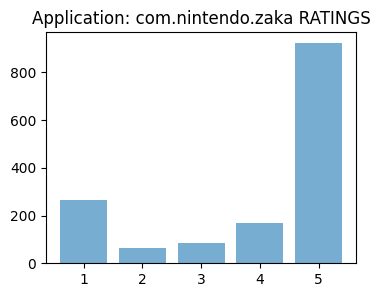

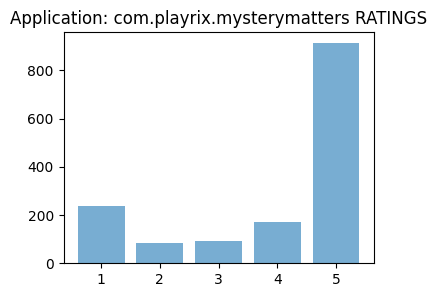

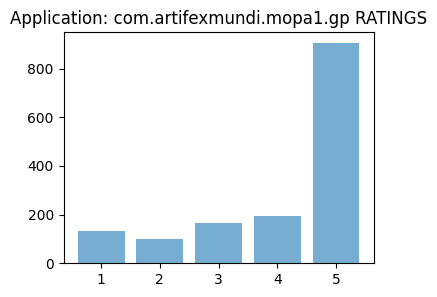

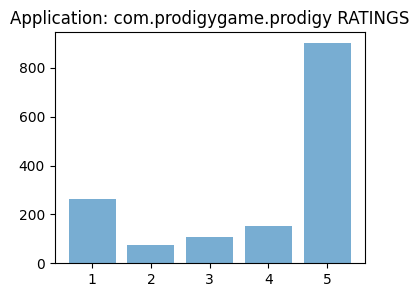

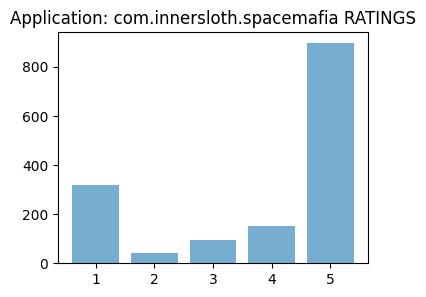

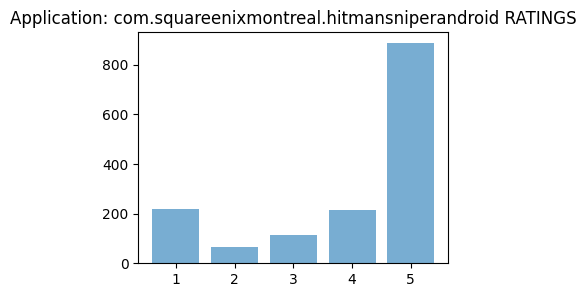

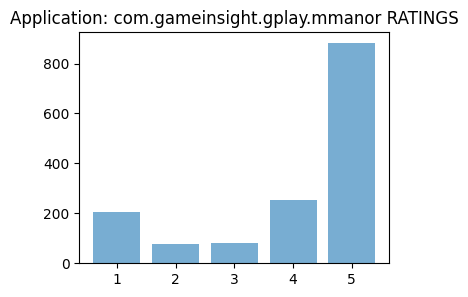

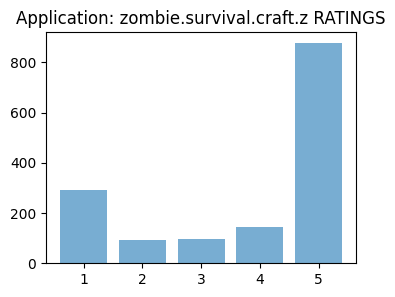

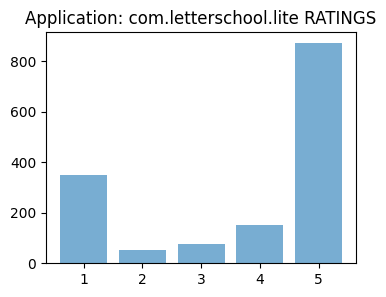

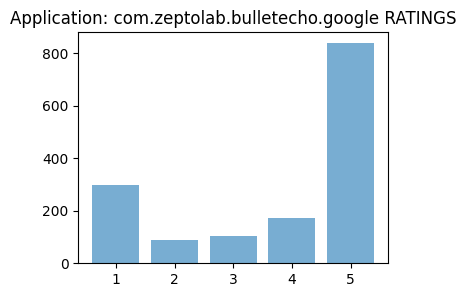

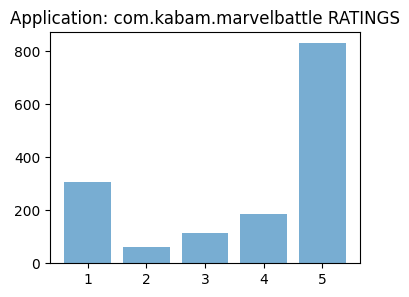

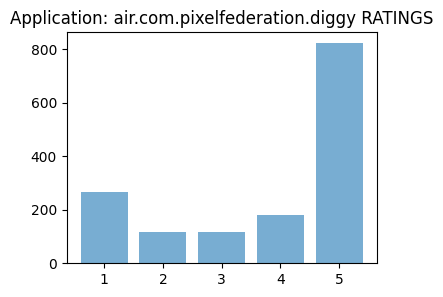

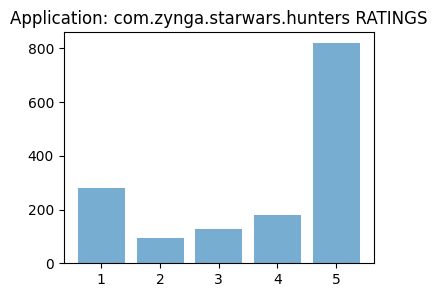

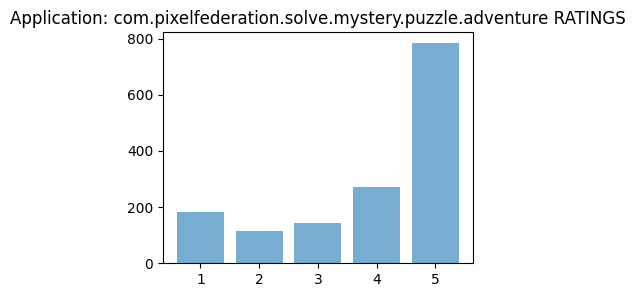

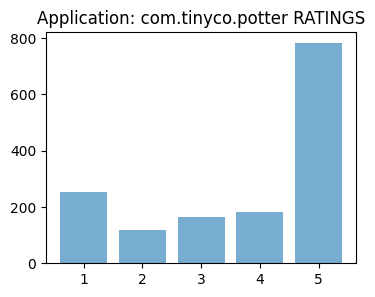

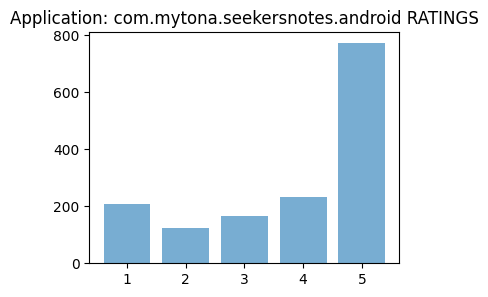

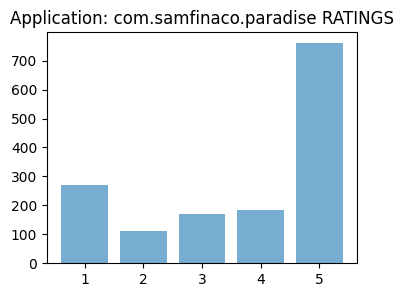

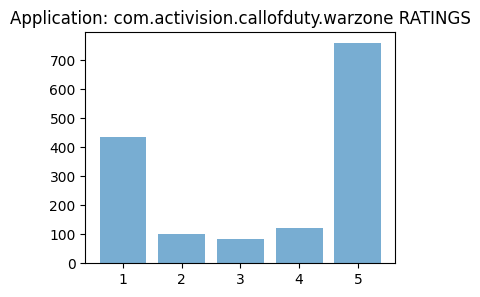

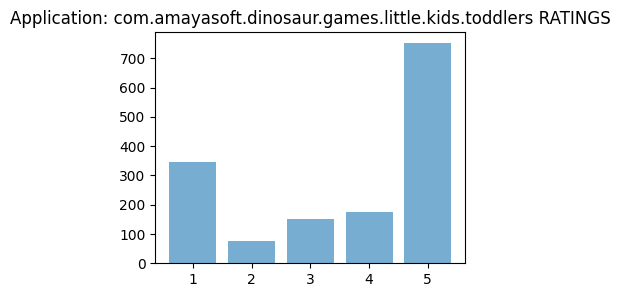

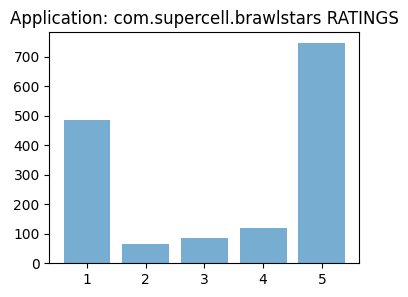

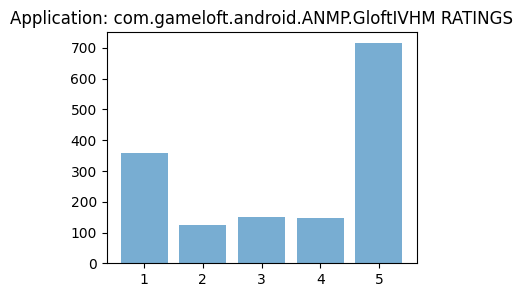

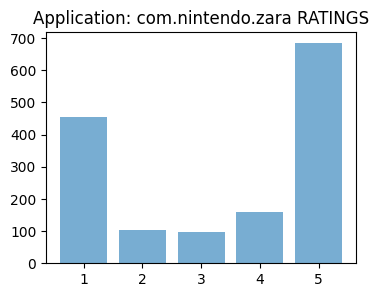

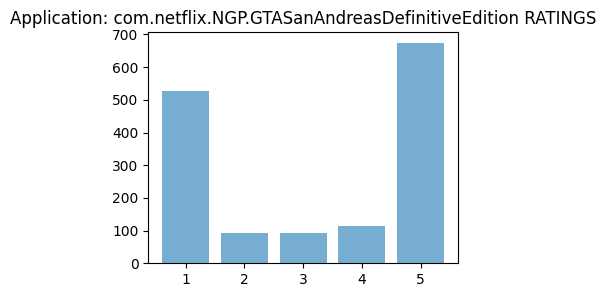

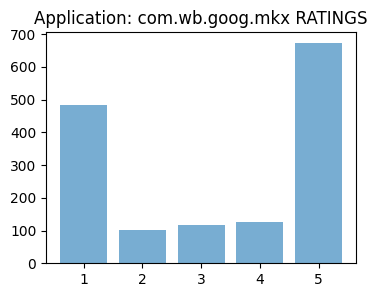

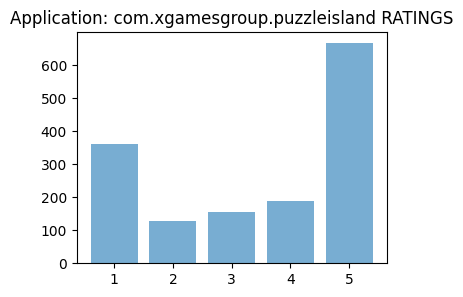

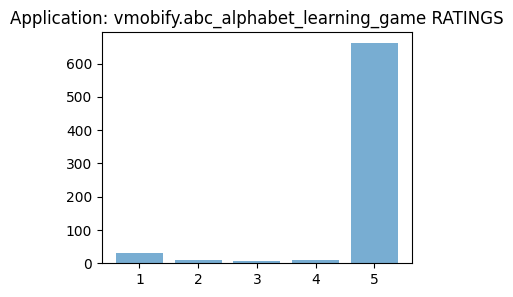

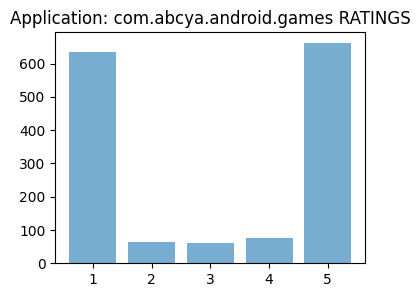

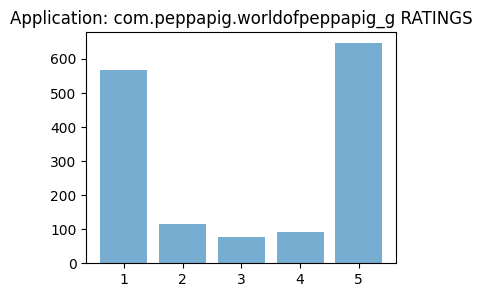

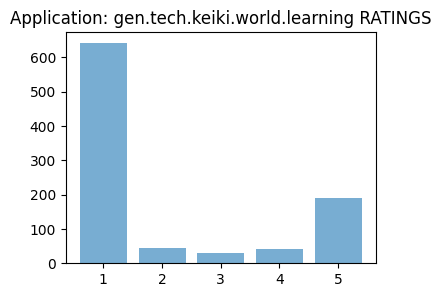

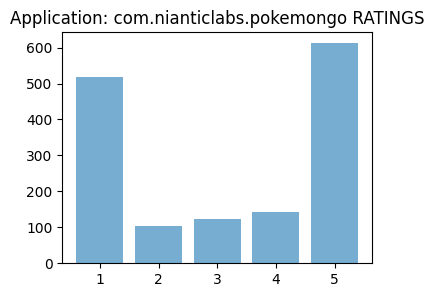

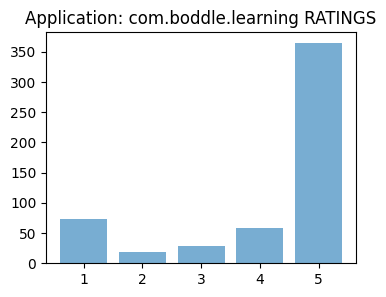

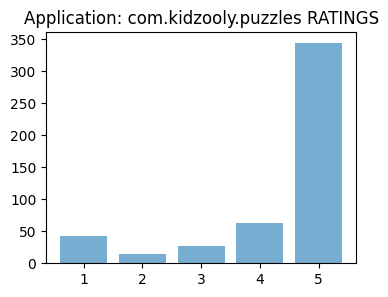

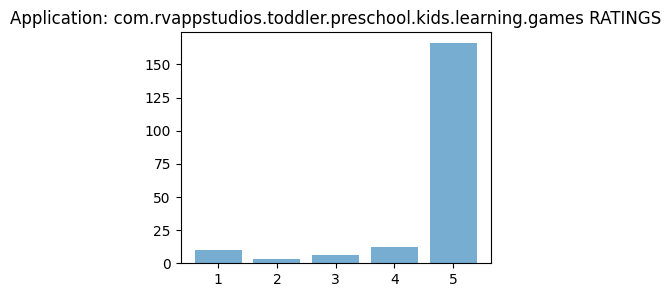

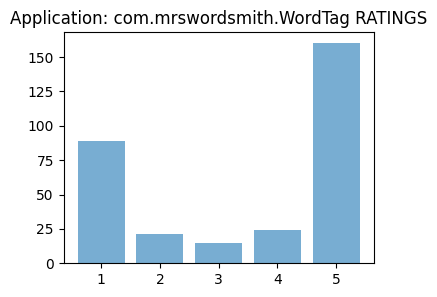

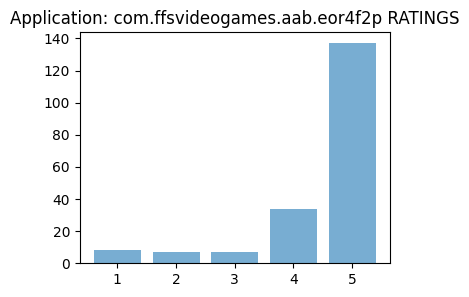

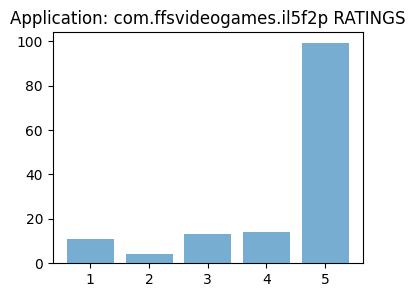

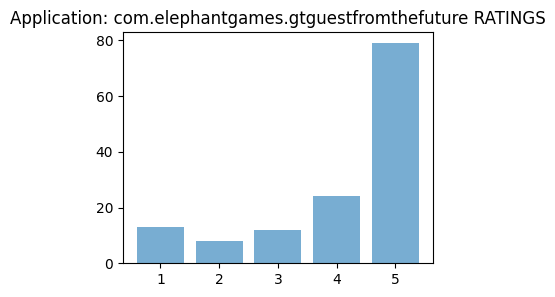

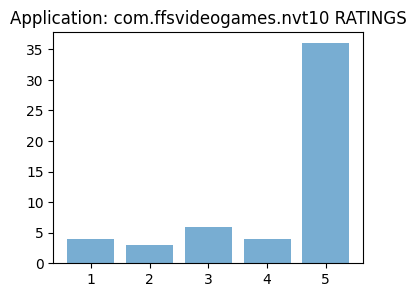

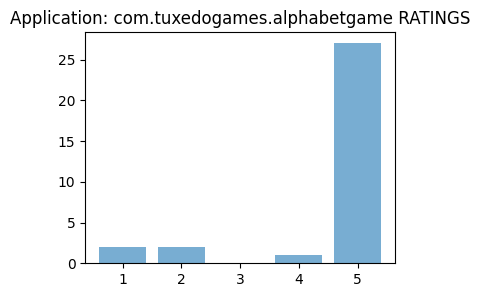

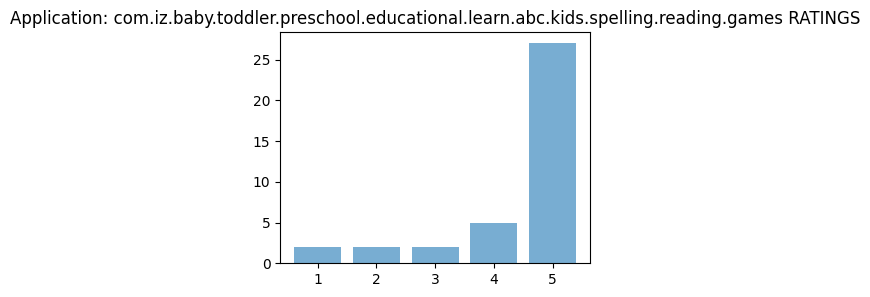

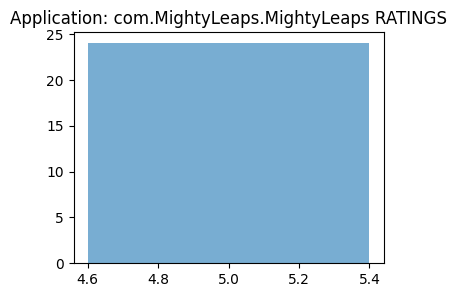

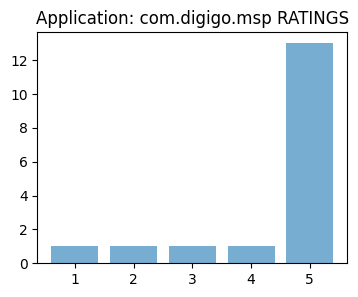

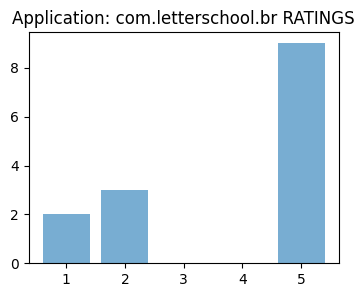

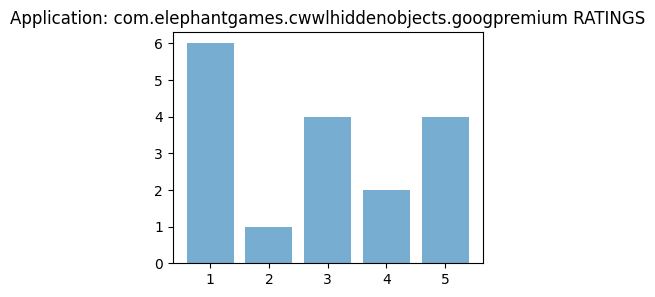

In [35]:
data = df[['appId','score']].value_counts().reset_index()

for app in data['appId'].unique():
    data_filter = data[data['appId'] == app].sort_values(by = 'count', ascending = True)
    fig, ax = plt.subplots(figsize = (4,3))
    plt.bar(data_filter['score'], data_filter['count'], alpha = 0.6)
    plt.title(f"Application: {app} RATINGS")
    plt.show()
    

Insights:
- Most of the games are rated by 5.
- There are games that 1 start ratings are high.

### Likes (ThumbsUpCount)
- Creating bins for Likes Feature to see the distribution clearly.
- Could we use this as a basis for influential user comments?

In [36]:
df['bins_thumbsUpCount'] = pd.cut(df['thumbsUpCount'], bins = [-float('inf'), 1, 10, 50, 200, 1000, float('inf')], labels = ['0_LIKES','1-10_LIKES','10-50_LIKES','50-200_LIKES', '200-1000_LIKES','1000-above_LIKES'])

In [37]:
df['bins_thumbsUpCount'].value_counts().reset_index()

bins_thumbsUpCount   count
0            0_LIKES  106309
1         1-10_LIKES    9390
2        10-50_LIKES    3259
3       50-200_LIKES    1331
4     200-1000_LIKES     513
5   1000-above_LIKES      70

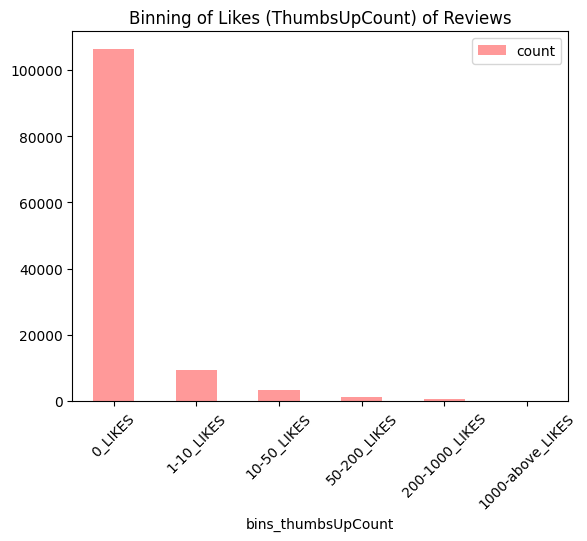

In [38]:
(df['bins_thumbsUpCount'].value_counts().reset_index()).plot(x = 'bins_thumbsUpCount', y = 'count', kind = 'bar', alpha =0.4, color = 'red')
plt.title('Binning of Likes (ThumbsUpCount) of Reviews')
plt.xticks(rotation = 45)
plt.show()

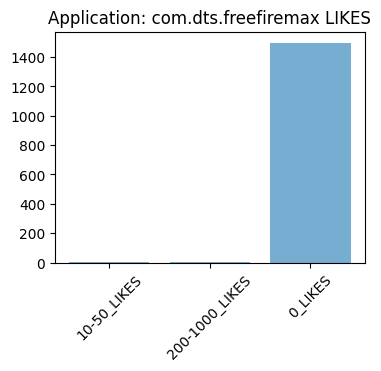

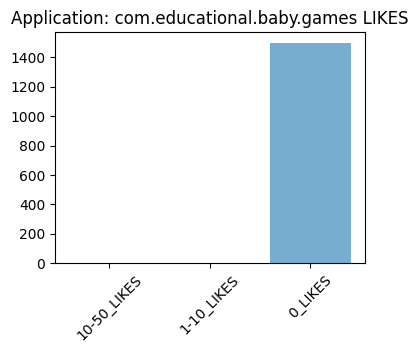

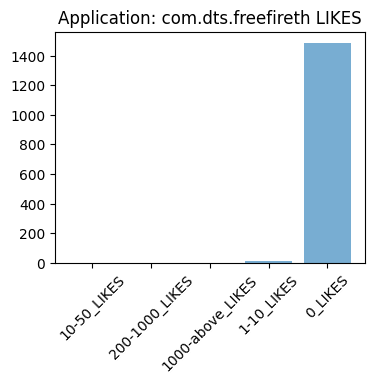

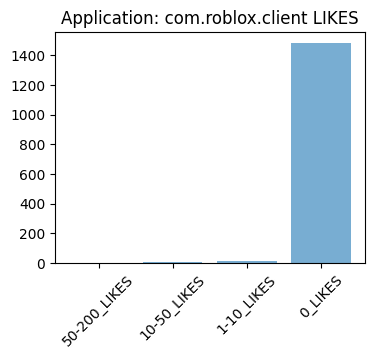

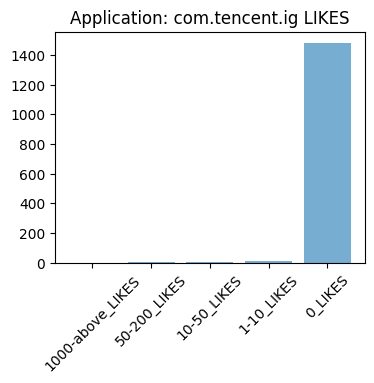

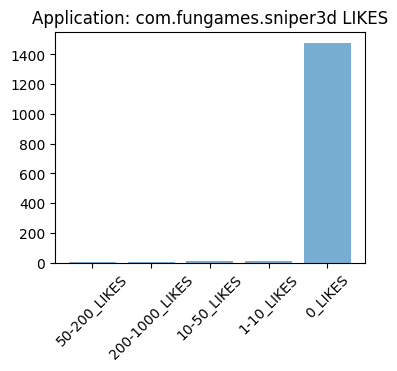

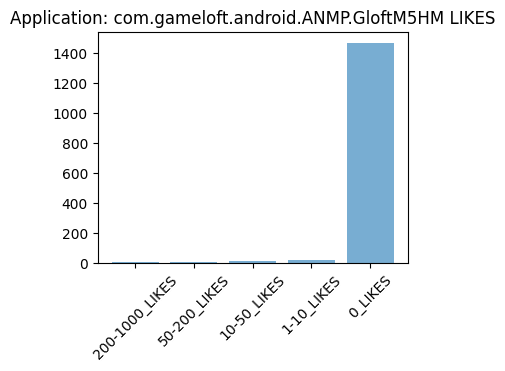

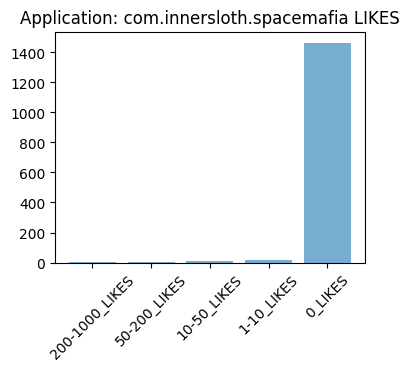

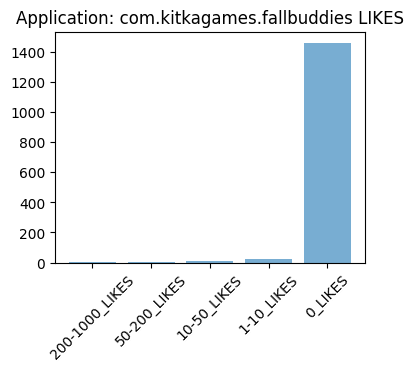

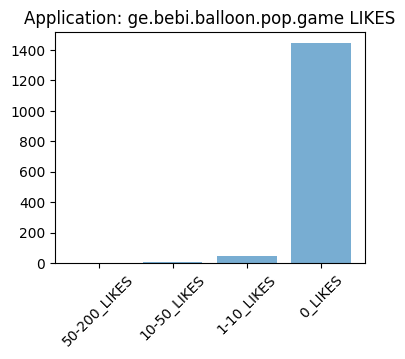

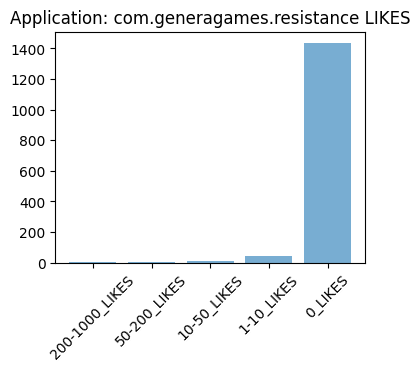

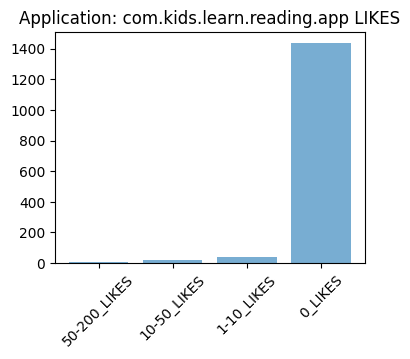

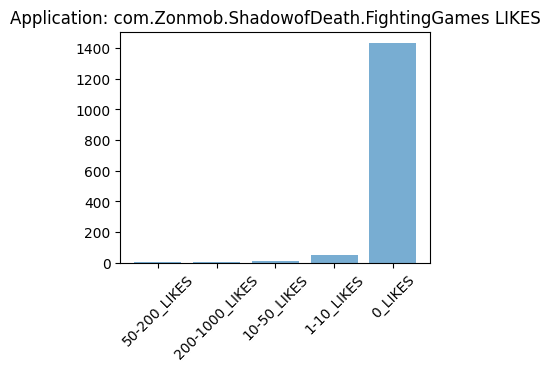

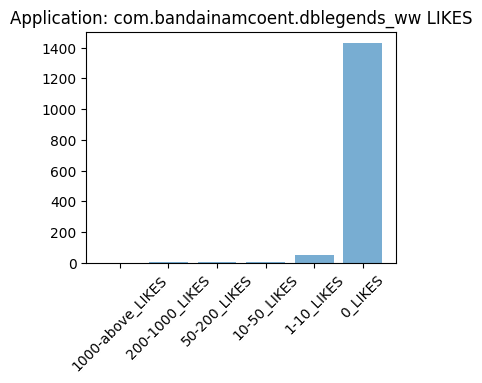

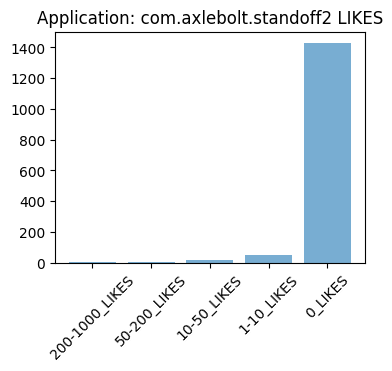

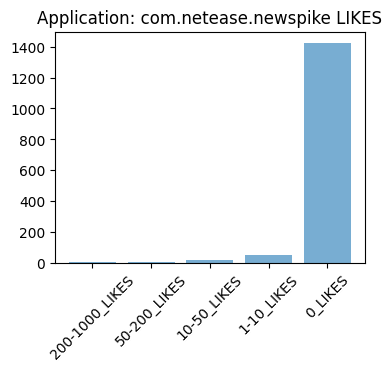

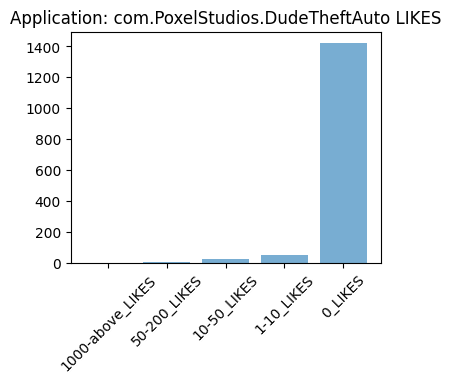

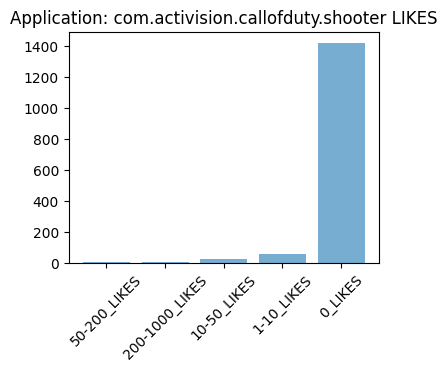

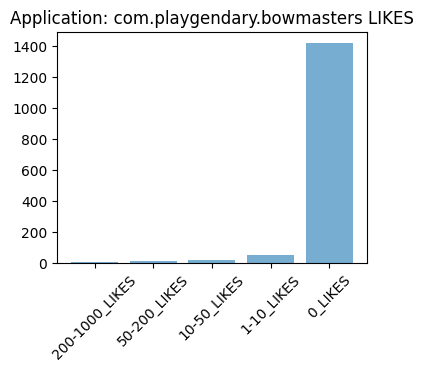

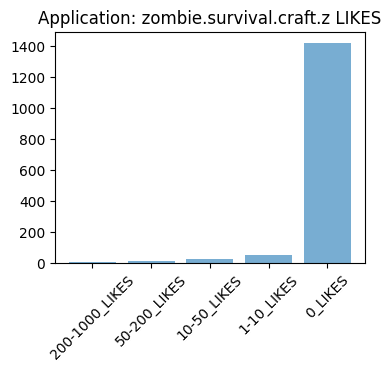

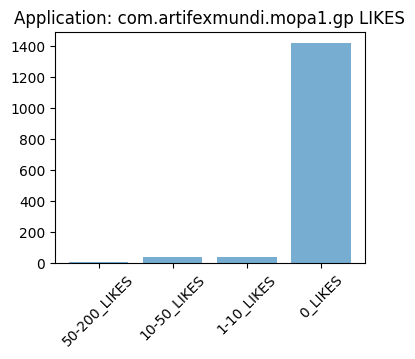

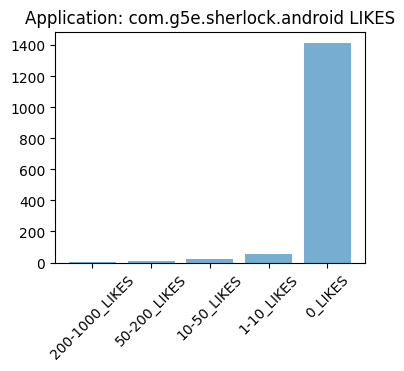

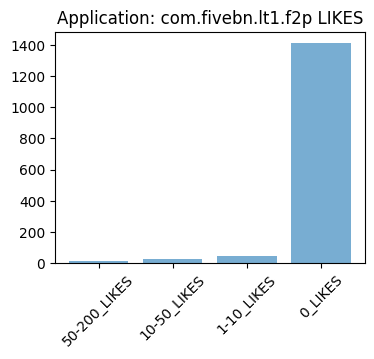

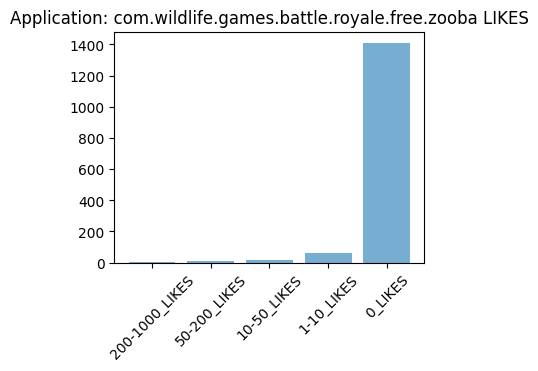

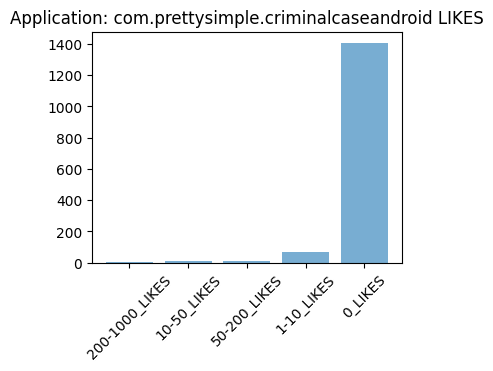

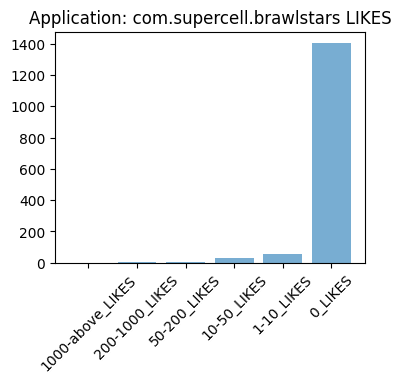

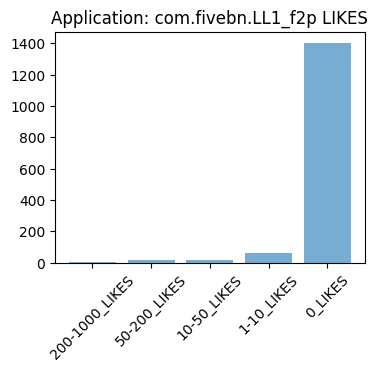

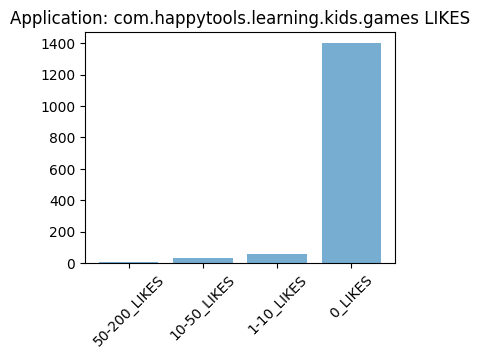

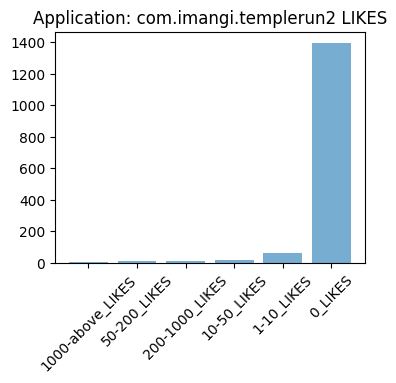

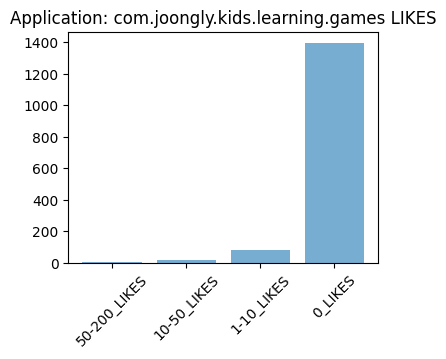

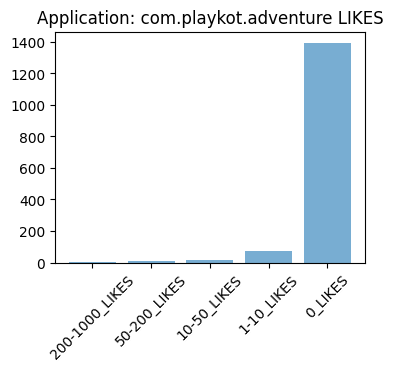

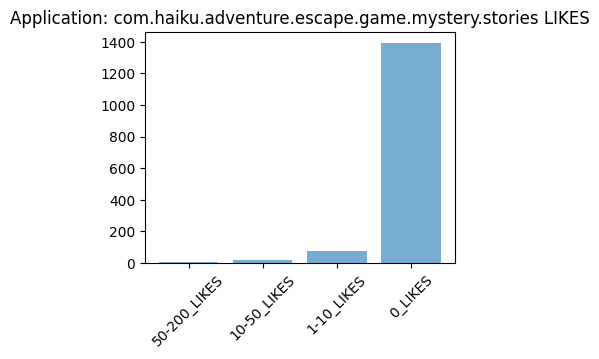

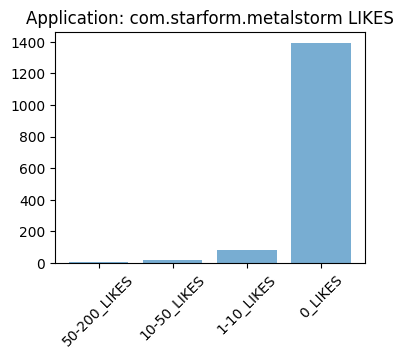

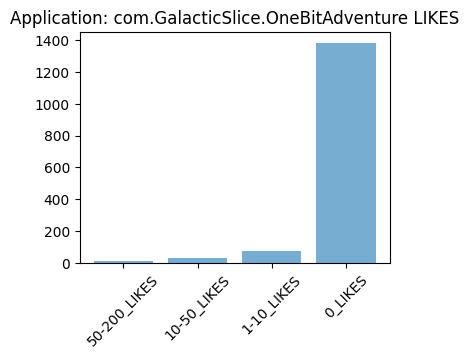

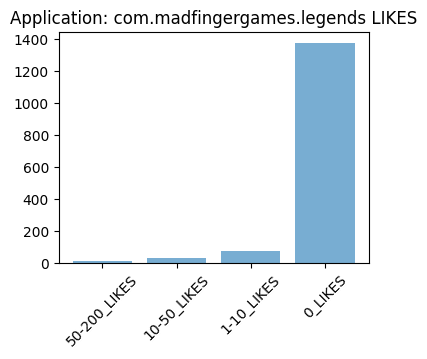

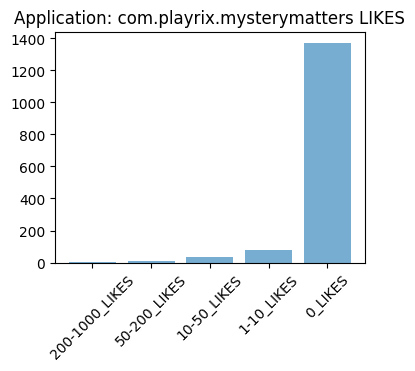

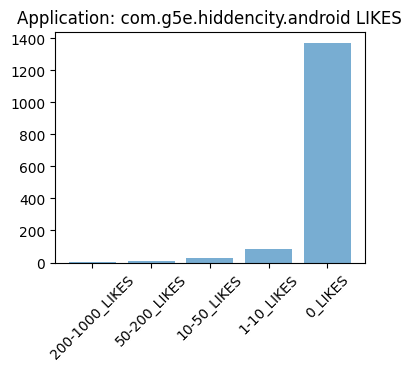

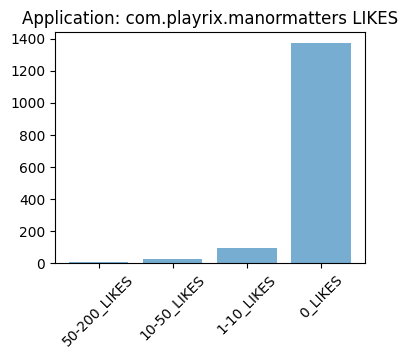

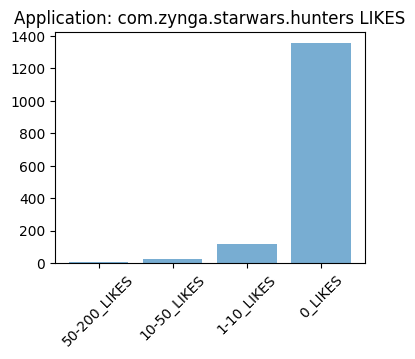

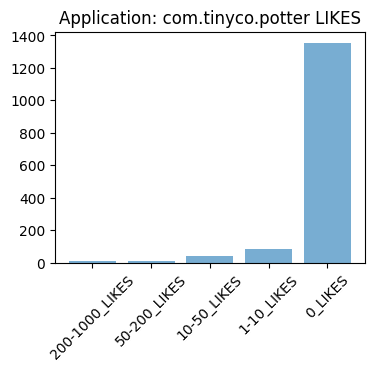

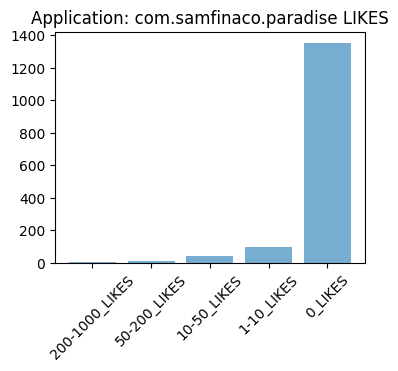

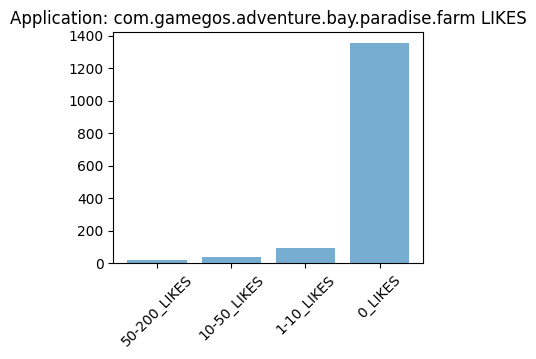

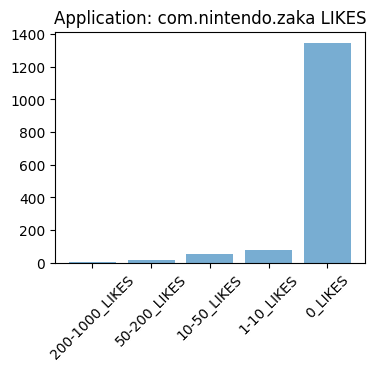

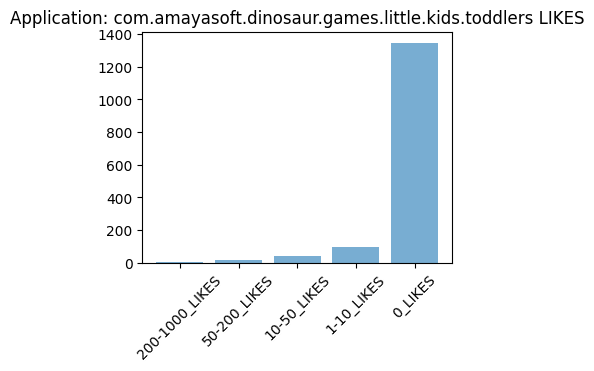

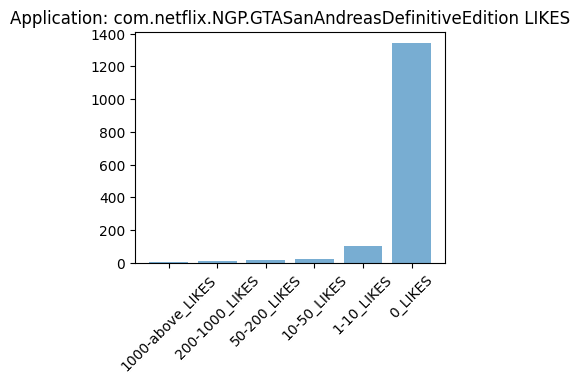

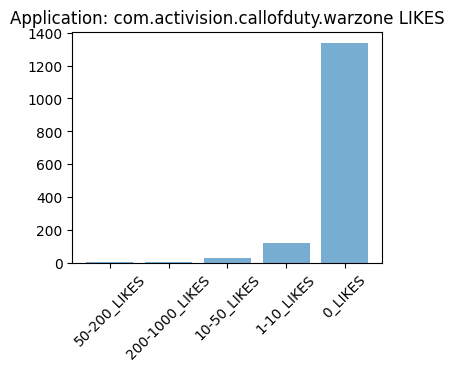

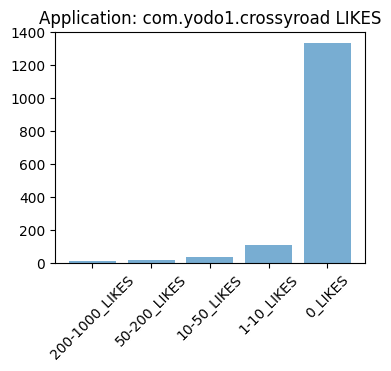

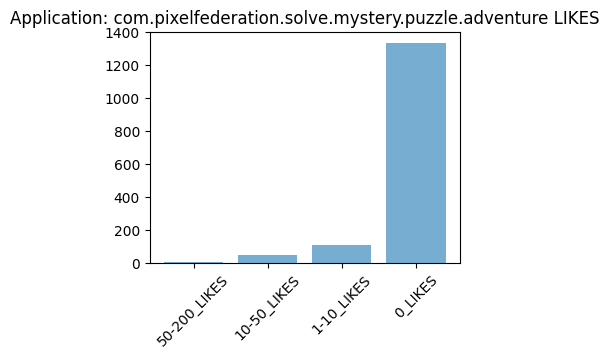

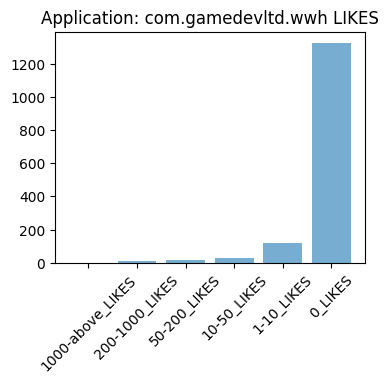

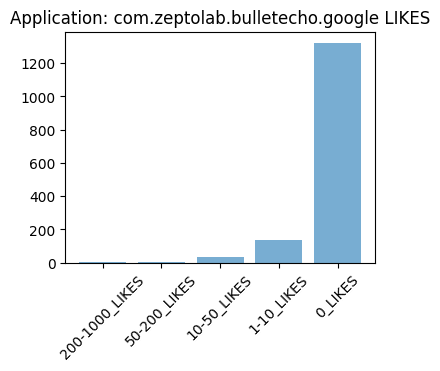

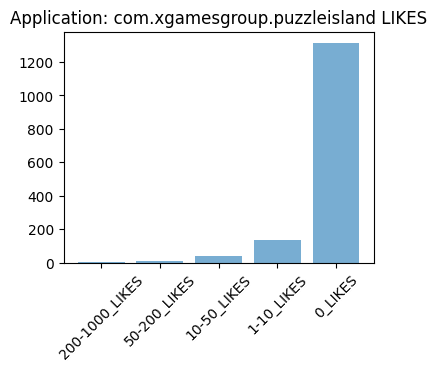

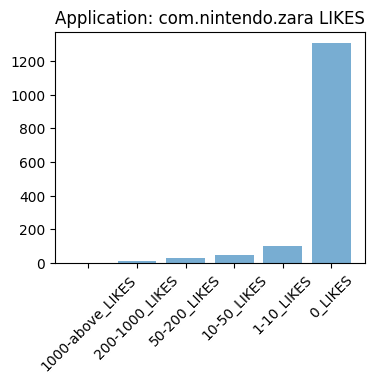

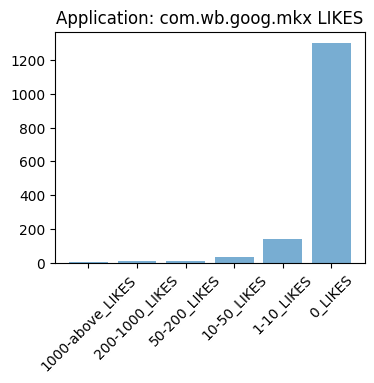

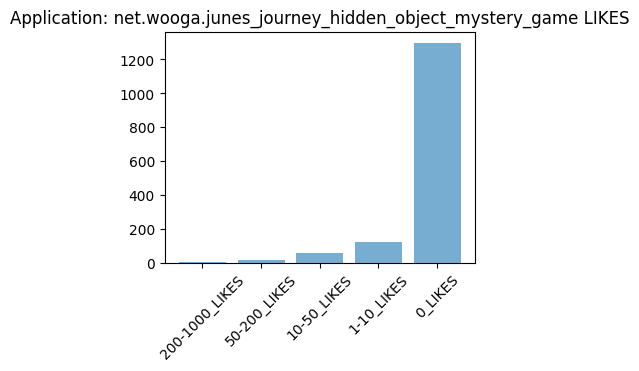

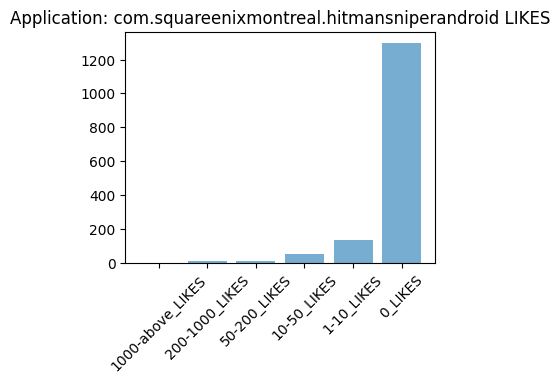

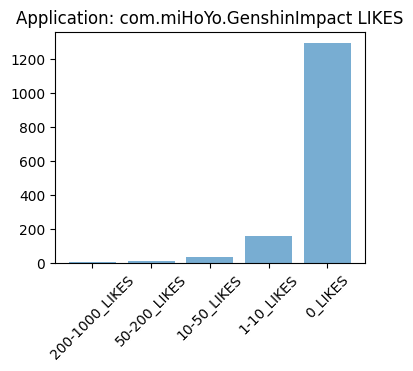

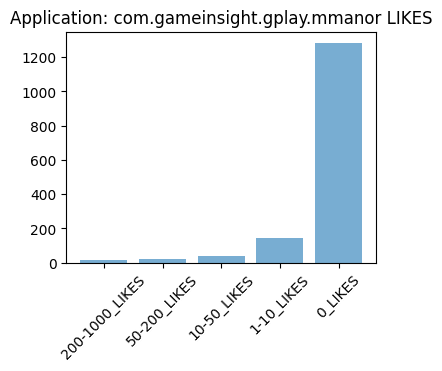

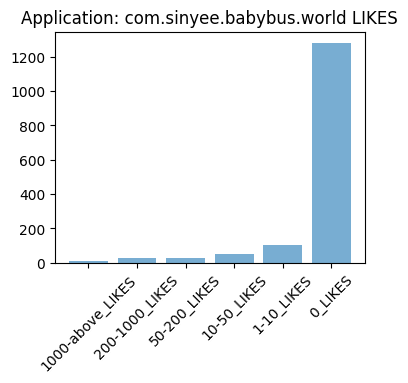

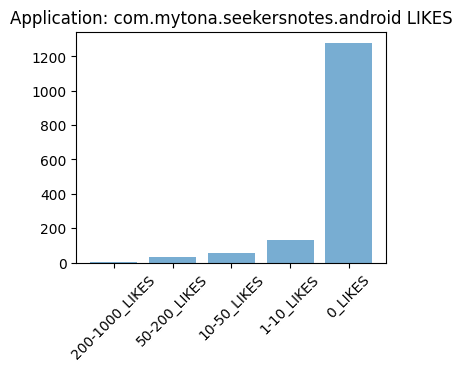

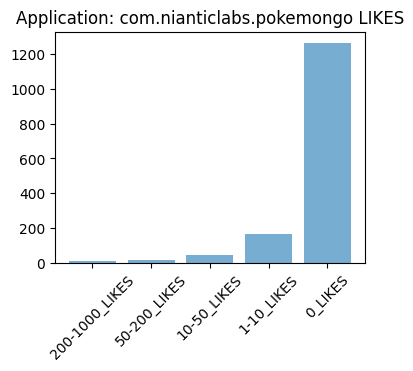

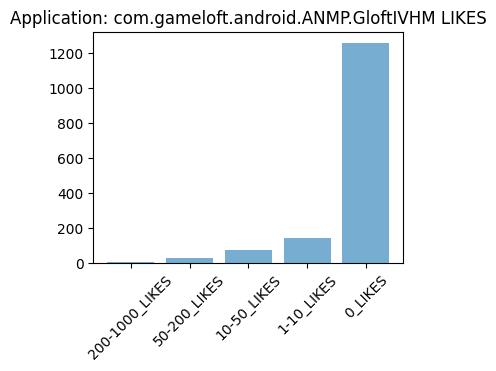

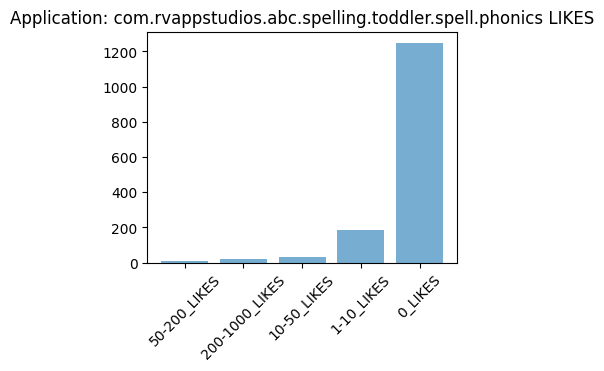

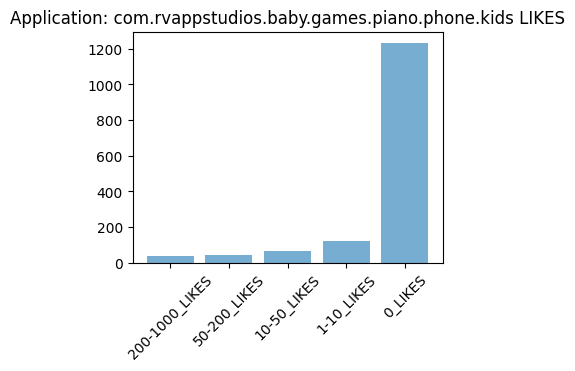

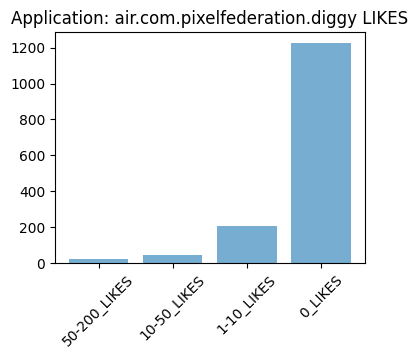

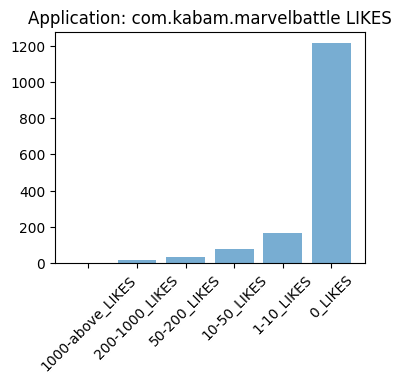

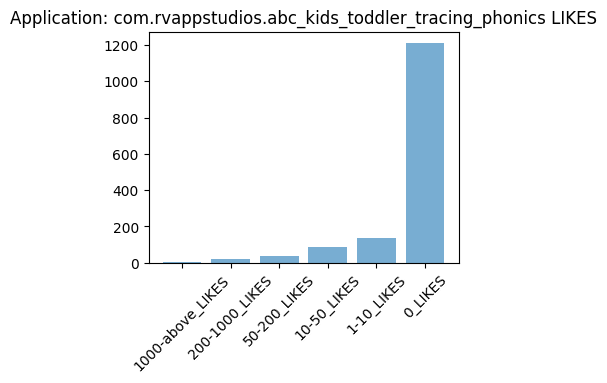

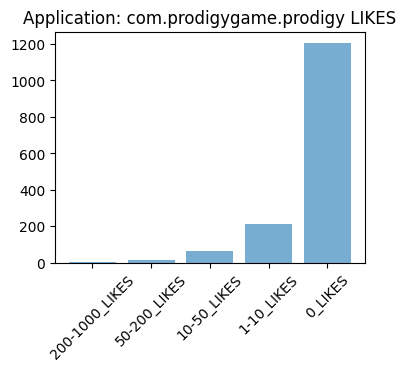

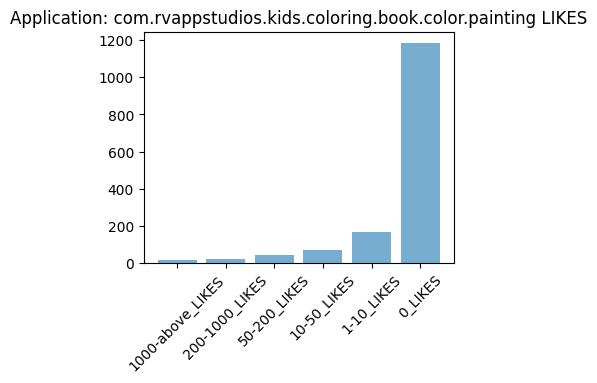

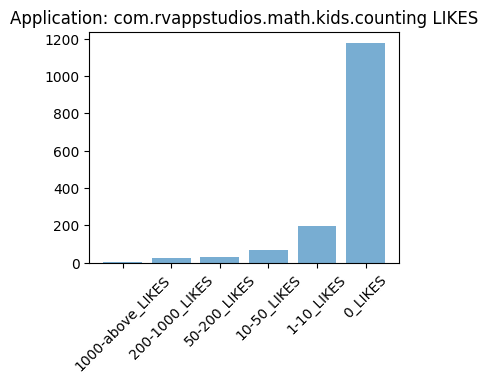

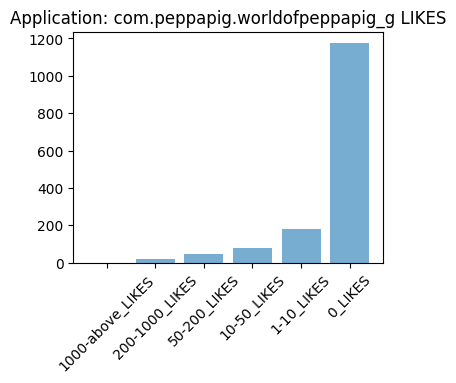

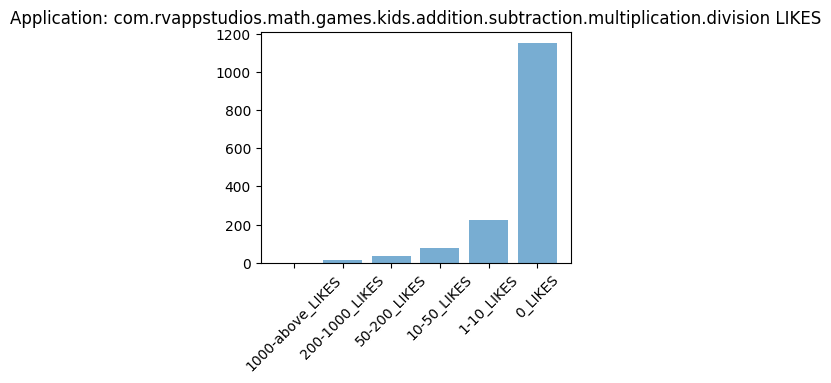

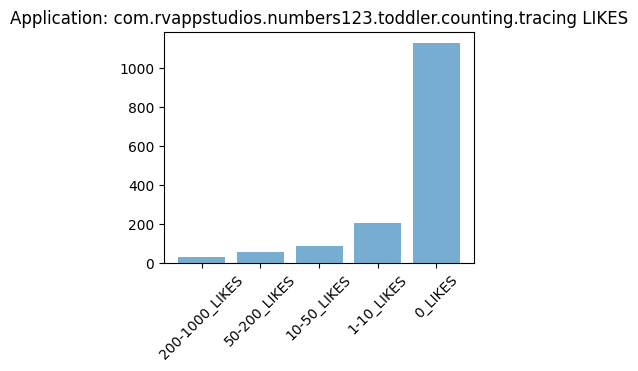

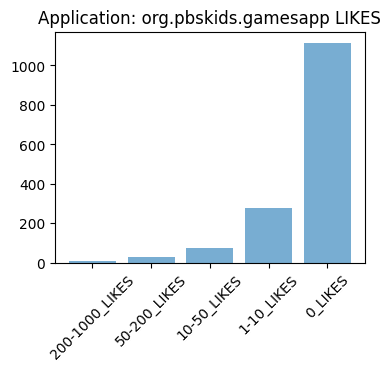

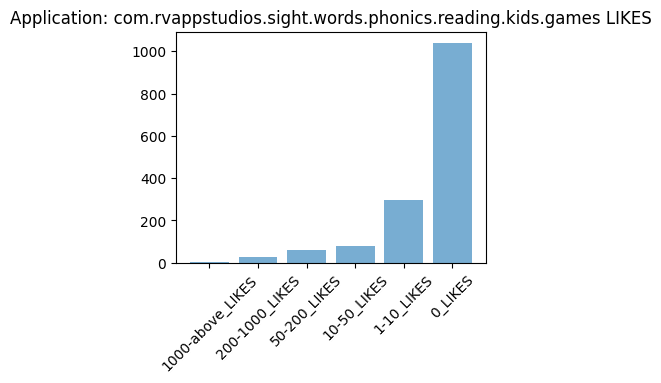

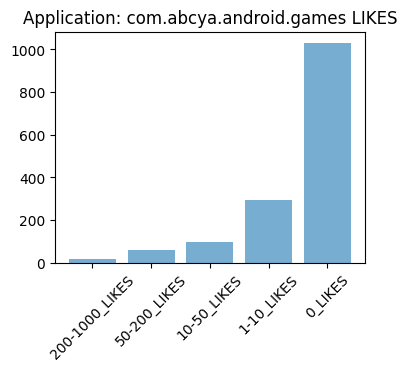

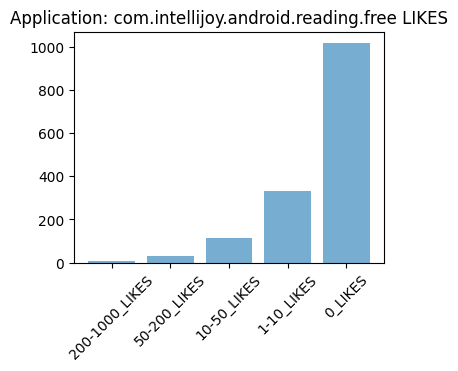

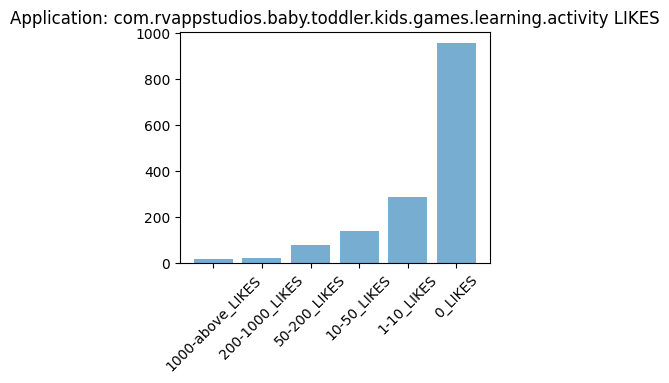

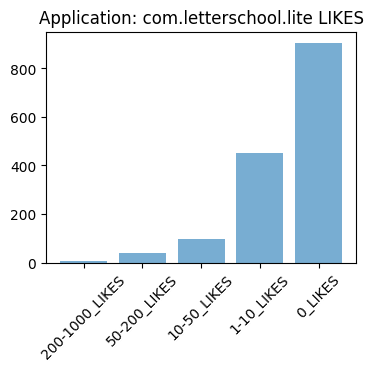

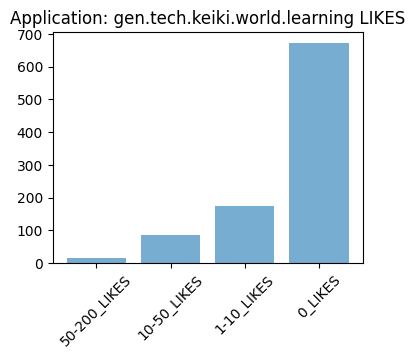

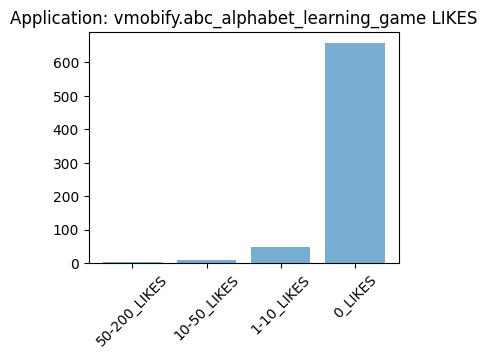

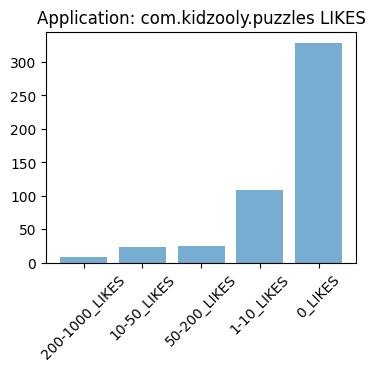

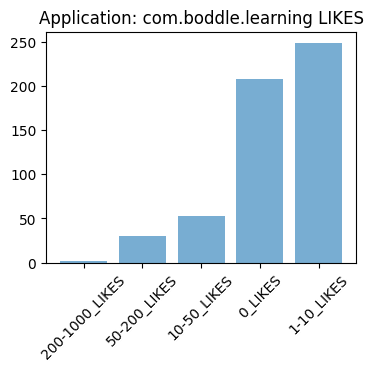

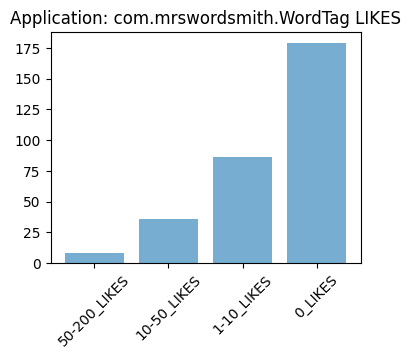

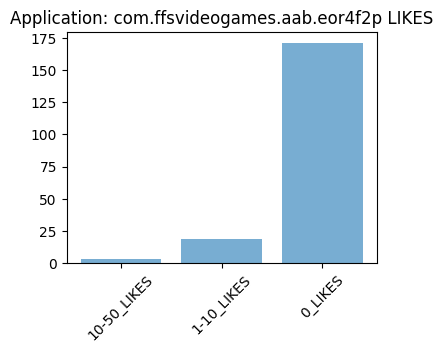

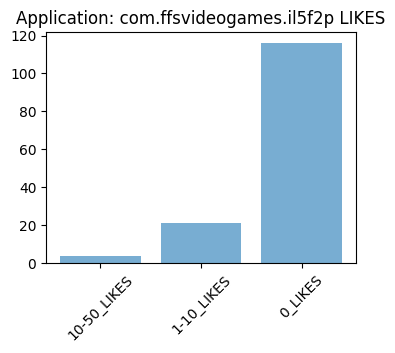

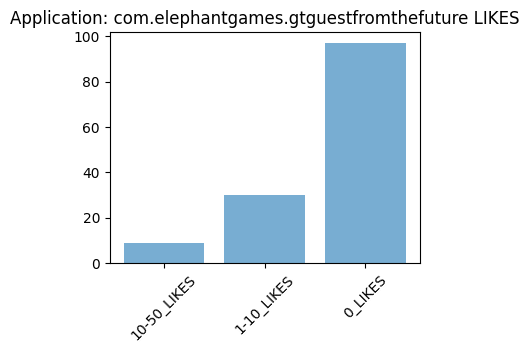

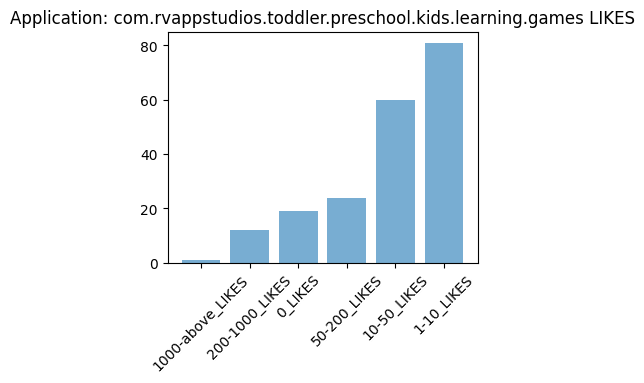

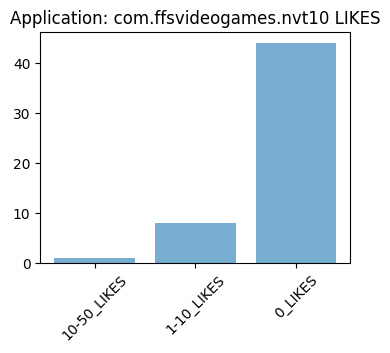

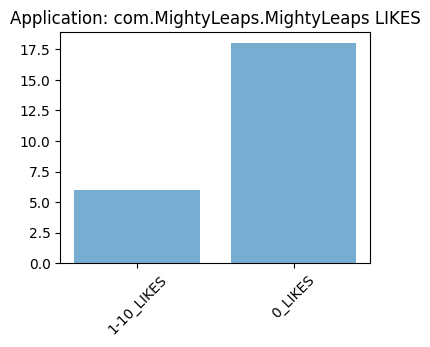

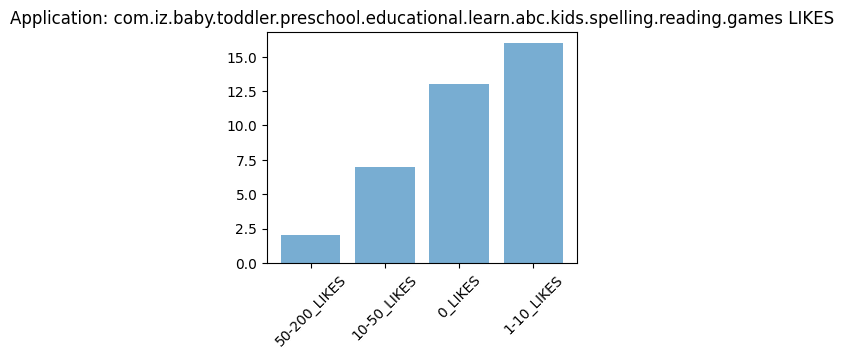

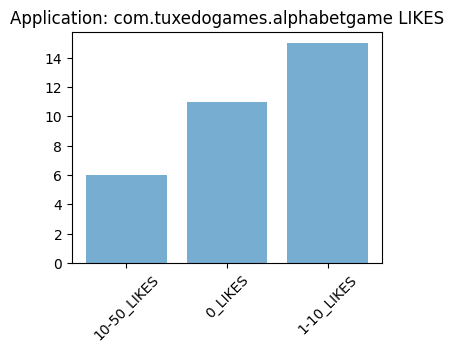

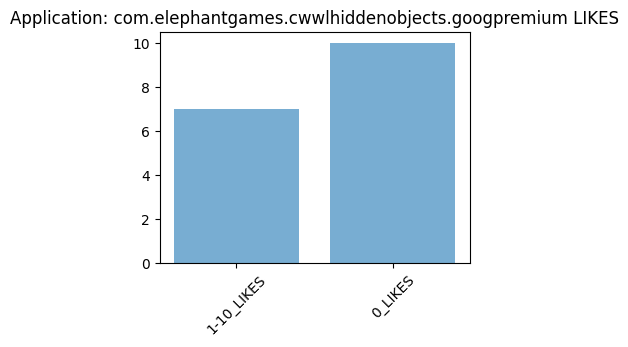

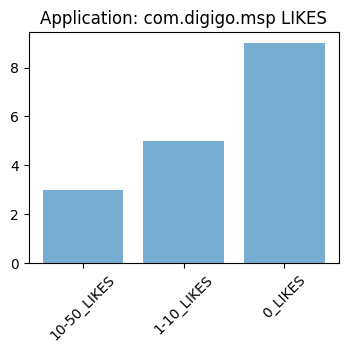

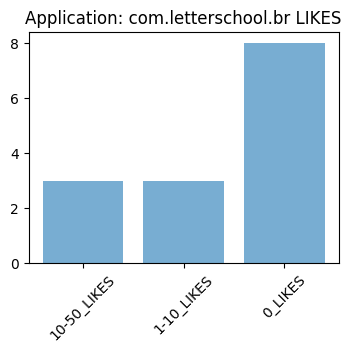

In [39]:
data = df[['appId','bins_thumbsUpCount']].value_counts().reset_index()

for app in data['appId'].unique():
    data_filter = data[data['appId'] == app].sort_values(by = 'count', ascending = True)
    fig, ax = plt.subplots(figsize = (4,3))
    plt.bar(data_filter['bins_thumbsUpCount'], data_filter['count'], alpha = 0.6)
    plt.title(f"Application: {app} LIKES")
    plt.xticks(rotation = 45)
    plt.show()

Insights: 
- There are a lot of games that has zero likes. 
- Decreasing like patterns are observed for higher bins/categories of likes.

### Review Comments of Influential Criteria

Looking at single-element comments. Comments that contains single-words which may not be insightful in topic modeling.

In [40]:
df[(df['content'].fillna('').str.split().apply(len) == 1)][['userName','score','content', 'replyContent']].head()

userName  score content   replyContent
2                                 Hashir Ashfaq      5     amp           None
4                               Zanele Gwamanda      3    free           None
15  Karen Mae N. Bermudes Karen Mae N. Bermudes      2      😸😺  😔 Why 2 star?
19                             anandhi vinoliya      5    nice           None
20                                  Nahid Ahmed      4      ok           None

In [41]:
print(f"{100*len(df[(df['content'].fillna('').str.split().apply(len) == 1)])/len(df):.2f}% of {len(df)} total data rows, contains single-element comments")

13.74% of 120872 total data rows, contains single-element comments


#### App Developer Reply on User Review

In [42]:
df[(pd.notnull(df['replyContent']))][['userName','score','content', 'replyContent']].head()

userName  score  \
11                                 Ranjit Singh      1   
15  Karen Mae N. Bermudes Karen Mae N. Bermudes      2   
21                         Hanaa zakawat Husain      5   
45                               Maizel Amazona      2   
53                               Ayomide Samuel      1   

                                              content  \
11  Wrong pronunciation of punjabi alphabets. Kind...   
15                                                 😸😺   
21  For the first time ever, my 6 old autistic son...   
45                                               Nice   
53                                              Baby.   

                                         replyContent  
11  We've forwarded your feedback to our developer...  
15                                      😔 Why 2 star?  
21  Thank you for sharing your review, it's review...  
45  Why 2 🌟? 😭😭😭, If you like app then I hope you ...  
53                                        Why 1 star?

Comment/Reply back made by the Developer on User's content.

In [43]:
print(f"{100*len(df[(pd.notnull(df['replyContent']))])/len(df):.2f}% of {len(df)} total data rows, contains feedbacks/replies from App Developer")

27.52% of 120872 total data rows, contains feedbacks/replies from App Developer


### So far.. 
- Our initial assumption is to based influential user comments on their review likes.
- We discovered that roughly 75k of our data has zero likes. A big chunk of data will be lost if we filter out comments/reviews without likes. Lets explore more the zero likes data.

##### Exploring the Zero Likes Data

In [44]:
df[(pd.notnull(df['replyContent'])) & (df['thumbsUpCount'] == 0)].head()

reviewId  \
11  3718e0b9-3994-42aa-b07d-268e2fd18c98   
15  3d6de22d-a864-4645-9542-1be81d8f09f2   
45  3e98be2b-881e-4808-8b33-b8fb235808e3   
53  6f7b6d0f-9b55-4908-bc52-44d29dcab09f   
55  dcf79996-56f5-4c9d-b524-69bb62b10ae5   

                                       userName  \
11                                 Ranjit Singh   
15  Karen Mae N. Bermudes Karen Mae N. Bermudes   
45                               Maizel Amazona   
53                               Ayomide Samuel   
55                                        Aysha   

                                            userImage  \
11  https://play-lh.googleusercontent.com/a-/ALV-U...   
15  https://play-lh.googleusercontent.com/a/ACg8oc...   
45  https://play-lh.googleusercontent.com/a-/ALV-U...   
53  https://play-lh.googleusercontent.com/a/ACg8oc...   
55  https://play-lh.googleusercontent.com/a/ACg8oc...   

                                              content  score  thumbsUpCount  \
11  Wrong pronunciation of punjabi alphabets. Kind...      1              0   
15                                                 😸😺      2              0   
45                                               Nice      2              0   
53                                              Baby.      1              0   
55                    Very nice ☺️🙂☺️🙂☺️🙂☺️🙂🙂 🙂👍🙂👍🙂👍🙂      2              0   

   reviewCreatedVersion                  at  \
11                2.0.5 2024-11-19 00:59:42   
15                 None 2024-11-17 05:33:37   
45                 None 2024-11-03 15:51:57   
53                 None 2024-11-01 04:25:41   
55                 None 2024-10-31 09:54:26   

                                         replyContent           repliedAt  \
11  We've forwarded your feedback to our developer... 2024-11-22 16:58:43   
15                                      😔 Why 2 star? 2024-11-22 16:58:25   
45  Why 2 🌟? 😭😭😭, If you like app then I hope you ... 2024-11-06 20:20:55   
53                                        Why 1 star? 2024-11-06 20:19:59   
55  Why 2 🌟? 😭😭😭, If you like app then I hope you ... 2024-11-06 20:19:49   

   appVersion                                              appId  \
11      2.0.5  com.rvappstudios.abc_kids_toddler_tracing_phonics   
15       None  com.rvappstudios.abc_kids_toddler_tracing_phonics   
45       None  com.rvappstudios.abc_kids_toddler_tracing_phonics   
53       None  com.rvappstudios.abc_kids_toddler_tracing_phonics   
55       None  com.rvappstudios.abc_kids_toddler_tracing_phonics   

   bins_thumbsUpCount  
11            0_LIKES  
15            0_LIKES  
45            0_LIKES  
53            0_LIKES  
55            0_LIKES

Feedbacks/Comments from App Developer, which can be considered an influential user criteria since they made the App Developer replied. 

In [45]:
print(f"{100*len(df[(pd.notnull(df['replyContent'])) & (df['thumbsUpCount'] == 0)])/len(df):.2f}% of {len(df)} total data rows, contains zero-liked reviews and has feedbacks/replies from App Developer")

19.42% of 120872 total data rows, contains zero-liked reviews and has feedbacks/replies from App Developer


In [46]:
print(f"{100*len(df[(pd.notnull(df['replyContent'])) & (df['thumbsUpCount'] == 0)])/len(df[(pd.notnull(df['replyContent']))]):.2f}% feedback/replies from App Developer, contains zero-liked reviews.")

70.56% feedback/replies from App Developer, contains zero-liked reviews.


Applying 2 or more review elements (words) for better review textual review info.

In [47]:
df[(pd.notnull(df['replyContent'])) & (df['thumbsUpCount'] == 0) & (df['content'].fillna('').str.split().apply(len) >= 2)][['userName','score','thumbsUpCount','content', 'replyContent']].head()

userName  score  thumbsUpCount  \
11       Ranjit Singh      1              0   
55              Aysha      2              0   
90          das Boots      5              0   
92   Jaslyn Ferrraren      1              0   
164       Ash Scarlet      1              0   

                                               content  \
11   Wrong pronunciation of punjabi alphabets. Kind...   
55                     Very nice ☺️🙂☺️🙂☺️🙂☺️🙂🙂 🙂👍🙂👍🙂👍🙂   
90       This app is a game changer. Thank you, Dave!!   
92                                rate how do you like   
164  So very good app you cant denied it so very co...   

                                          replyContent  
11   We've forwarded your feedback to our developer...  
55   Why 2 🌟? 😭😭😭, If you like app then I hope you ...  
90   The reviews from parents is what inspires us t...  
92   Why 1 star? Let us know what we can improve fo...  
164  😱😭 why 1 star? If you like it, will you consid...

In [48]:
print(f"{100*len(df[(pd.notnull(df['replyContent'])) & (df['thumbsUpCount'] == 0) & (df['content'].fillna('').str.split().apply(len) >= 2)])/len(df):.2f}% of {len(df)} total data rows, contains zero-liked reviews, feedbacks/replies from App Developer, and contains 2 or more elements")

16.39% of 120872 total data rows, contains zero-liked reviews, feedbacks/replies from App Developer, and contains 2 or more elements


### Analyzing relevancy of Single Token vs Two or more Tokens REVIEWS
---

#### Single Token Reviews

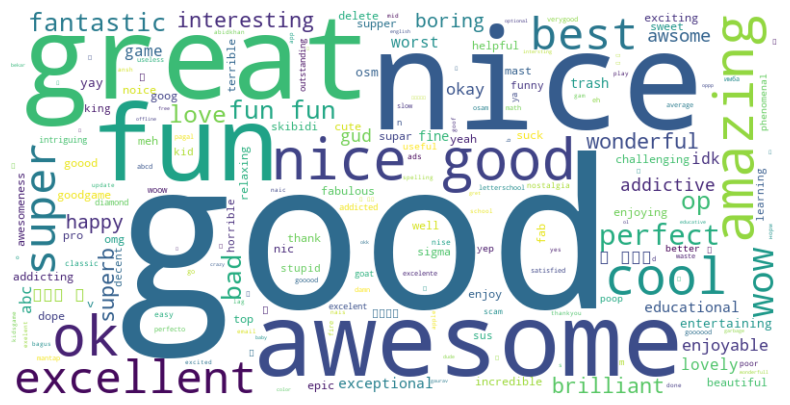

In [ ]:
from wordcloud import WordCloud, STOc

# User with atlteast 10 likes and Single Element/Word Review
wc_string = df[(df['content'].fillna('').str.split().apply(len) == 1)]['content'].str.lower().str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wc_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Insights: Wordcloud gives us generic reviews for single token reviews, which doesn't give us that much textual info.

#### Two tokens Reviews

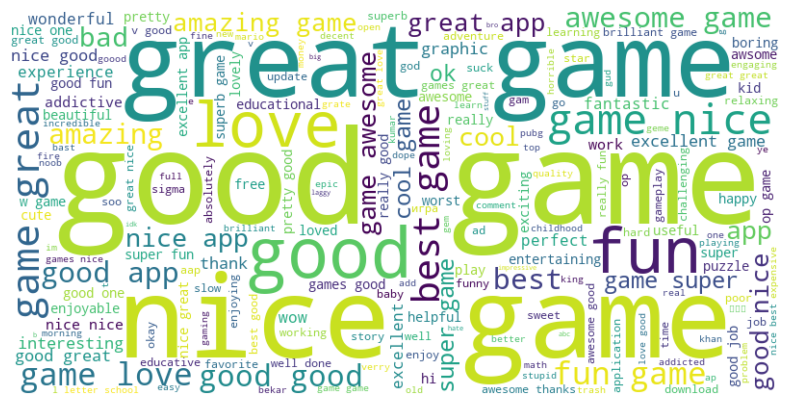

In [50]:
wc_string = df[(df['content'].fillna('').str.split().apply(len) == 2)]['content'].str.lower().str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wc_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Insights: Wordcloud gives us a better info compared to a single token reviews but it still gave us frequent generic reviews.

#### Three Tokens Reviews

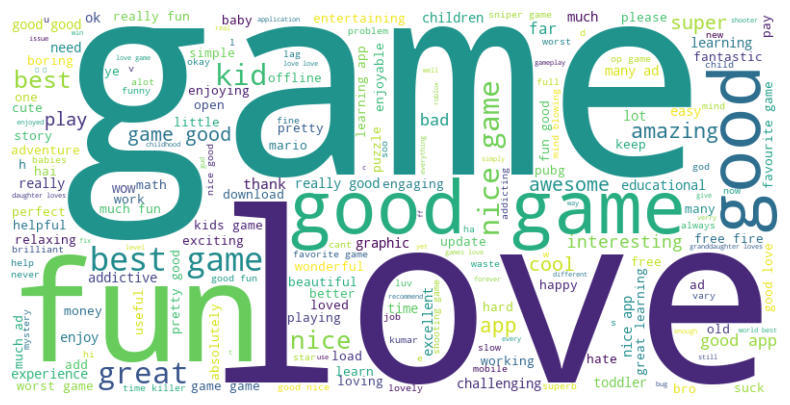

In [51]:
wc_string = df[(df['content'].fillna('').str.split().apply(len) == 3)]['content'].str.lower().str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wc_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Insights: Some interesting topics started pop out like children specific topics such words "toddler", "children" and more. It seems like 3 tokens and more would give us viable info for Influential Users with atleast 10 likes. 

#### Three Tokens & above Reviews with 10 & ABOVE LIKES

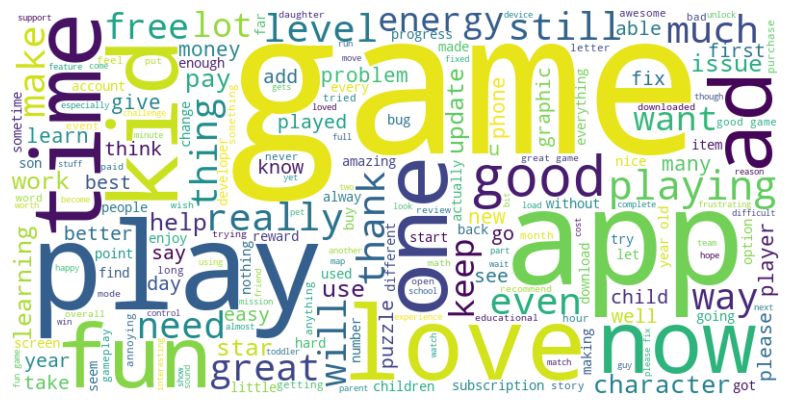

In [52]:
wc_string = df[(df['content'].fillna('').str.split().apply(len) >= 3) & (df['thumbsUpCount'] >= 10)]['content'].str.lower().str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wc_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Take note that the data will undergo preprocessing to eliminate noise and unrelevant words.

Initial: Three Tokens & above for Reviews with Devleoper Feedback. 

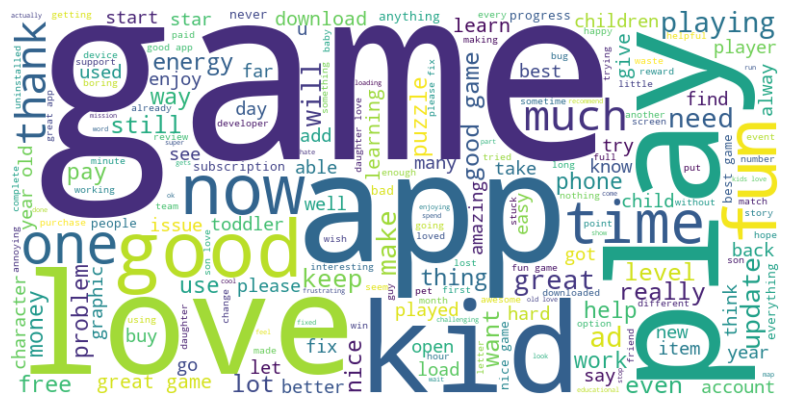

In [53]:
wc_string = df[(df['content'].fillna('').str.split().apply(len) >= 3) & (pd.notnull(df['replyContent']))]['content'].str.lower().str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wc_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

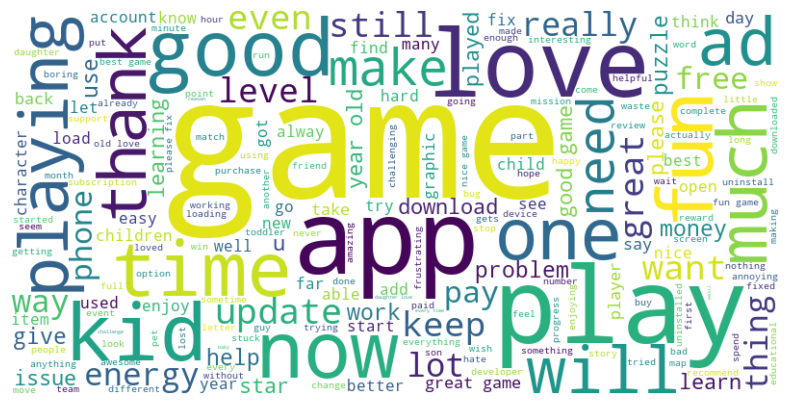

In [54]:
# Making it 6 and above token reviews for stricter rule since influential criteria is based on Developer Feedback flag.

wc_string = df[(df['content'].fillna('').str.split().apply(len) >= 6) & (pd.notnull(df['replyContent']))]['content'].str.lower().str.cat(sep=' ')
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(wc_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
a = len(df[(df['content'].fillna('').str.split().apply(len) >= 3) & (df['thumbsUpCount'] >= 10)])
b = len(df[(df['content'].fillna('').str.split().apply(len) >= 6) & (pd.notnull(df['replyContent']))])
print(f"Total of {a} for Reviews with 10 or more likes and 3 or more tokens, and {b} for Reviews with developer feedback and 6 or more tokens \nTotal of {a+b} for Influential User Reviews base")

Total of 5434 for Reviews with 10 or more likes and 3 or more tokens, and 19357 for Reviews with developer feedback and 6 or more tokens 
Total of 24791 for Influential User Reviews base


### Final Criteria for Influential User Reviews.
Given the data, Users should meet atleast 1 of the following criteria:
1. Review has 10 or more likes, and 3 or more words (tokens) in a review content.
2. App Developer gave feedback, and 6 or more words (tokens) in a review content.